<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/protein_tfidf_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from time import time
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import networkx as nx

n_samples = 2000
n_features = 1000
n_components = 5
n_top_words = 10

ngram_ranges = [9, 8, 7, 6, 5, 4, 3, 2, 1]

df = pd.read_csv("proteins_lhc.csv",)


In [36]:
def plot_top_words(model, feature_names, n_top_words, title):
    
    buf_df=pd.DataFrame()
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]


        # build resulting dataframe
        topic_df_name = f"Topic_{topic_idx +1}"
        buf_df[f"{topic_df_name}_node"] = top_features
        buf_df[f"{topic_df_name}_weight"] = weights


        # build horizontal bar chart per topic
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

    return buf_df

In [37]:
def build_graph_network(df_slice):

  import networkx as nx
  from networkx.algorithms.community.modularity_max import greedy_modularity_communities

  # build graph 
  G = nx.from_pandas_edgelist(df_slice
                            ,'source'          # parent
                            ,'target'          # child
                            , ['weight'])      # relationship


  # define plot area
  plt.figure(3,figsize=(22,22)) 

  # calc degrees per node
  d = dict(G.degree)

  # visualize graph 
  nx.draw(G         
      ,nx.kamada_kawai_layout(G)               
      ,with_labels=True
      ,edge_color='gray'
      ,node_color='lightskyblue'
      ,node_size=[v * 100 for v in d.values()]
      ,font_size=22)
  
  ax = plt.gca() # to get the current axis
  ax.collections[0].set_edgecolor("blue")

  return G

In [38]:
buf_list = []

for seq in df['protein']:
  buf_string = ''
  for amino in seq:
    buf_string = buf_string + amino + ' '
  buf_list.append(buf_string)
df['protein split'] = buf_list

In [39]:
# demonstrate amino acid split
df['protein split']

0     M A M A A V T G A V L S G L G S S F L S G G K ...
1     M A T T S A A V L N G L S S S F L T G G K N S ...
2     M A S L G V S E M L G T P L N F R A V S R S S ...
3     A T G C A A T T T A A A A A T A C T C C A C A ...
4     M A N F N V P K L G V F P V A A V F D I D N V ...
5     M K S E L M Q R L R L K Y P P P D G Y C R W G ...
6     F V P P G G G A G T G G T I A K D A L G N D V ...
7     M N T T I A H A A S S G R I E L L V R Q I R M ...
8     M S R T R W L M T G L C V A G A A G A L W S F ...
9     M G T G D W G L E I L D F R F W I L D F N L I ...
10    M A D K S D L G Y T G L T D E Q A Q E L H S V ...
11    P E N L R W F V Q A E L V N G R W A M L G V A ...
12    M L A N V V S R K A S G L R Q T P A R A T V A ...
13    M T I A V G R V T K E E N D L F P L I D D W L ...
14    M K P S D D K A Q L S G L A Q S E E S S L D V ...
15    M E S R V L L R A T A N V V G I P K L R R P I ...
16    M A S L Q V A D P N R I L F H S S S I P P R N ...
17    M G S I T V A P G T T V L F S S R R L D L 




amino acid ngram range of study - (9, 9)
Extracting tf-idf features for NMF...
done in 0.034s.
Extracting tf features for LDA...
done in 0.031s.



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


done in 0.321s.


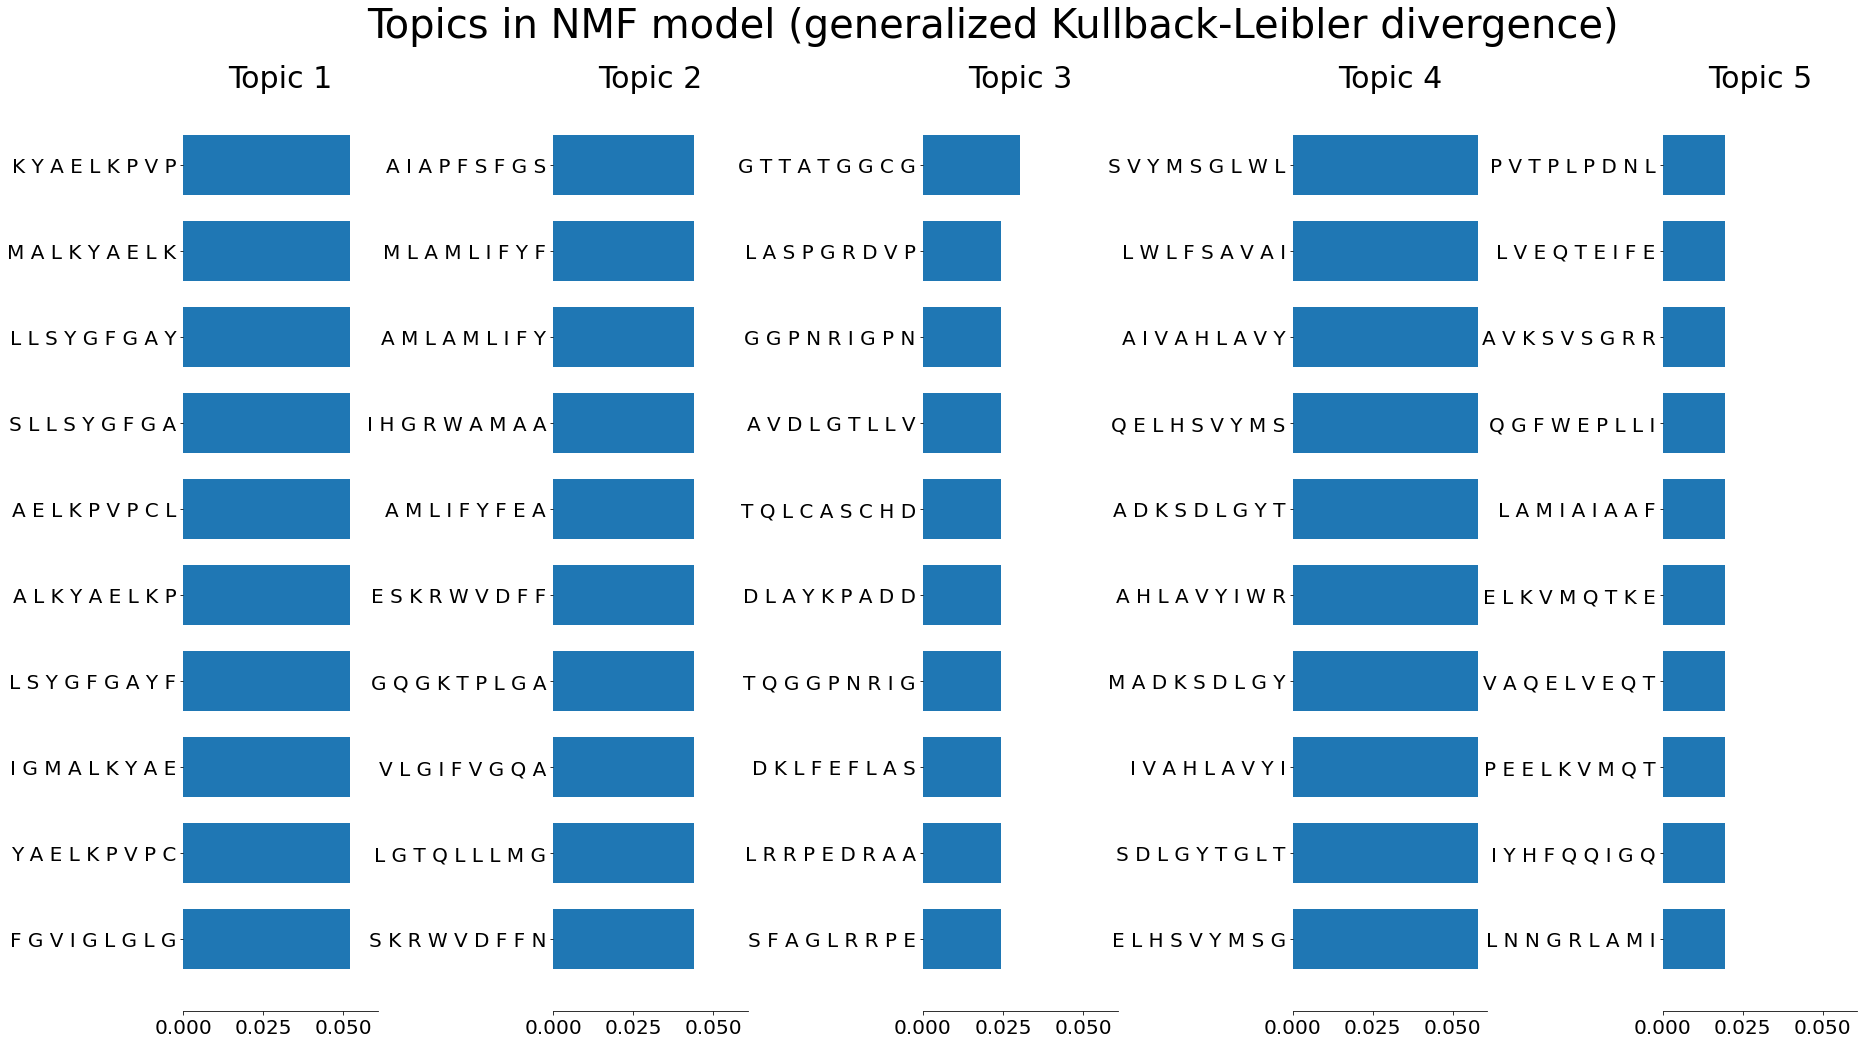



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


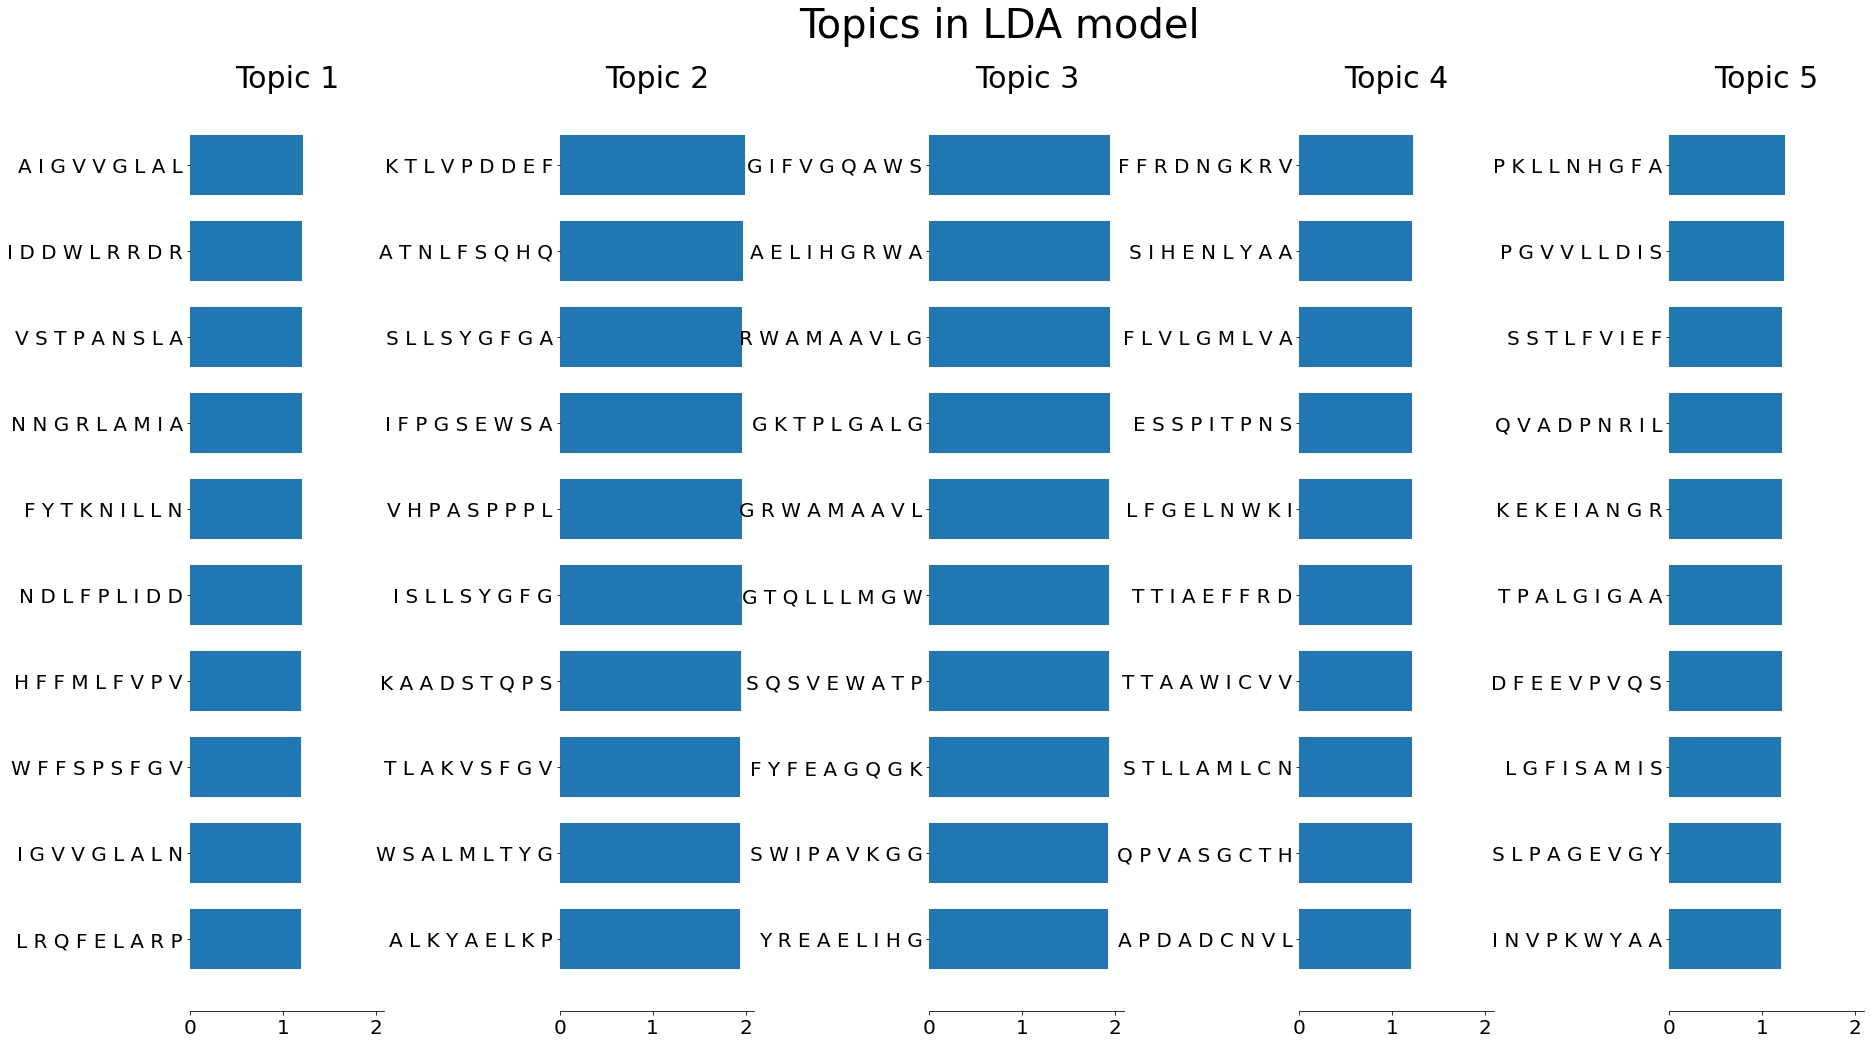




amino acid ngram range of study - (8, 8)
Extracting tf-idf features for NMF...
done in 0.049s.
Extracting tf features for LDA...
done in 0.073s.



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


done in 0.300s.


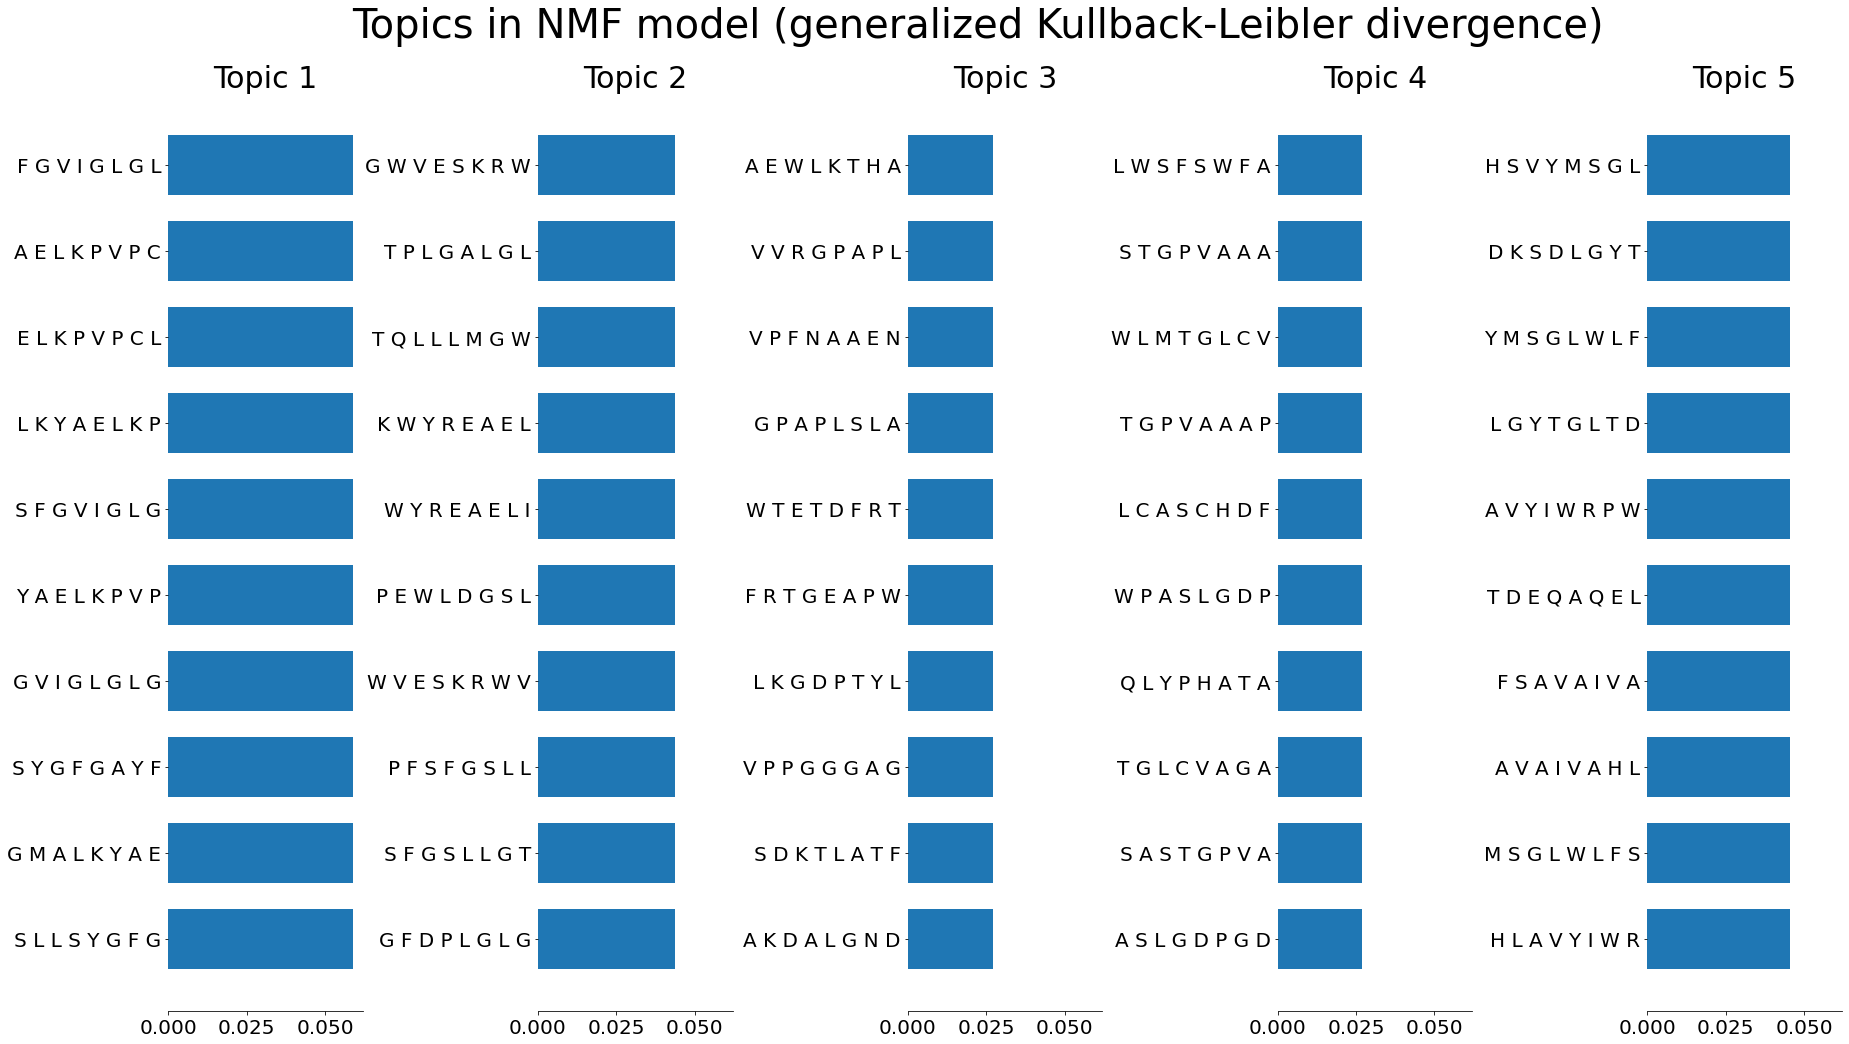



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


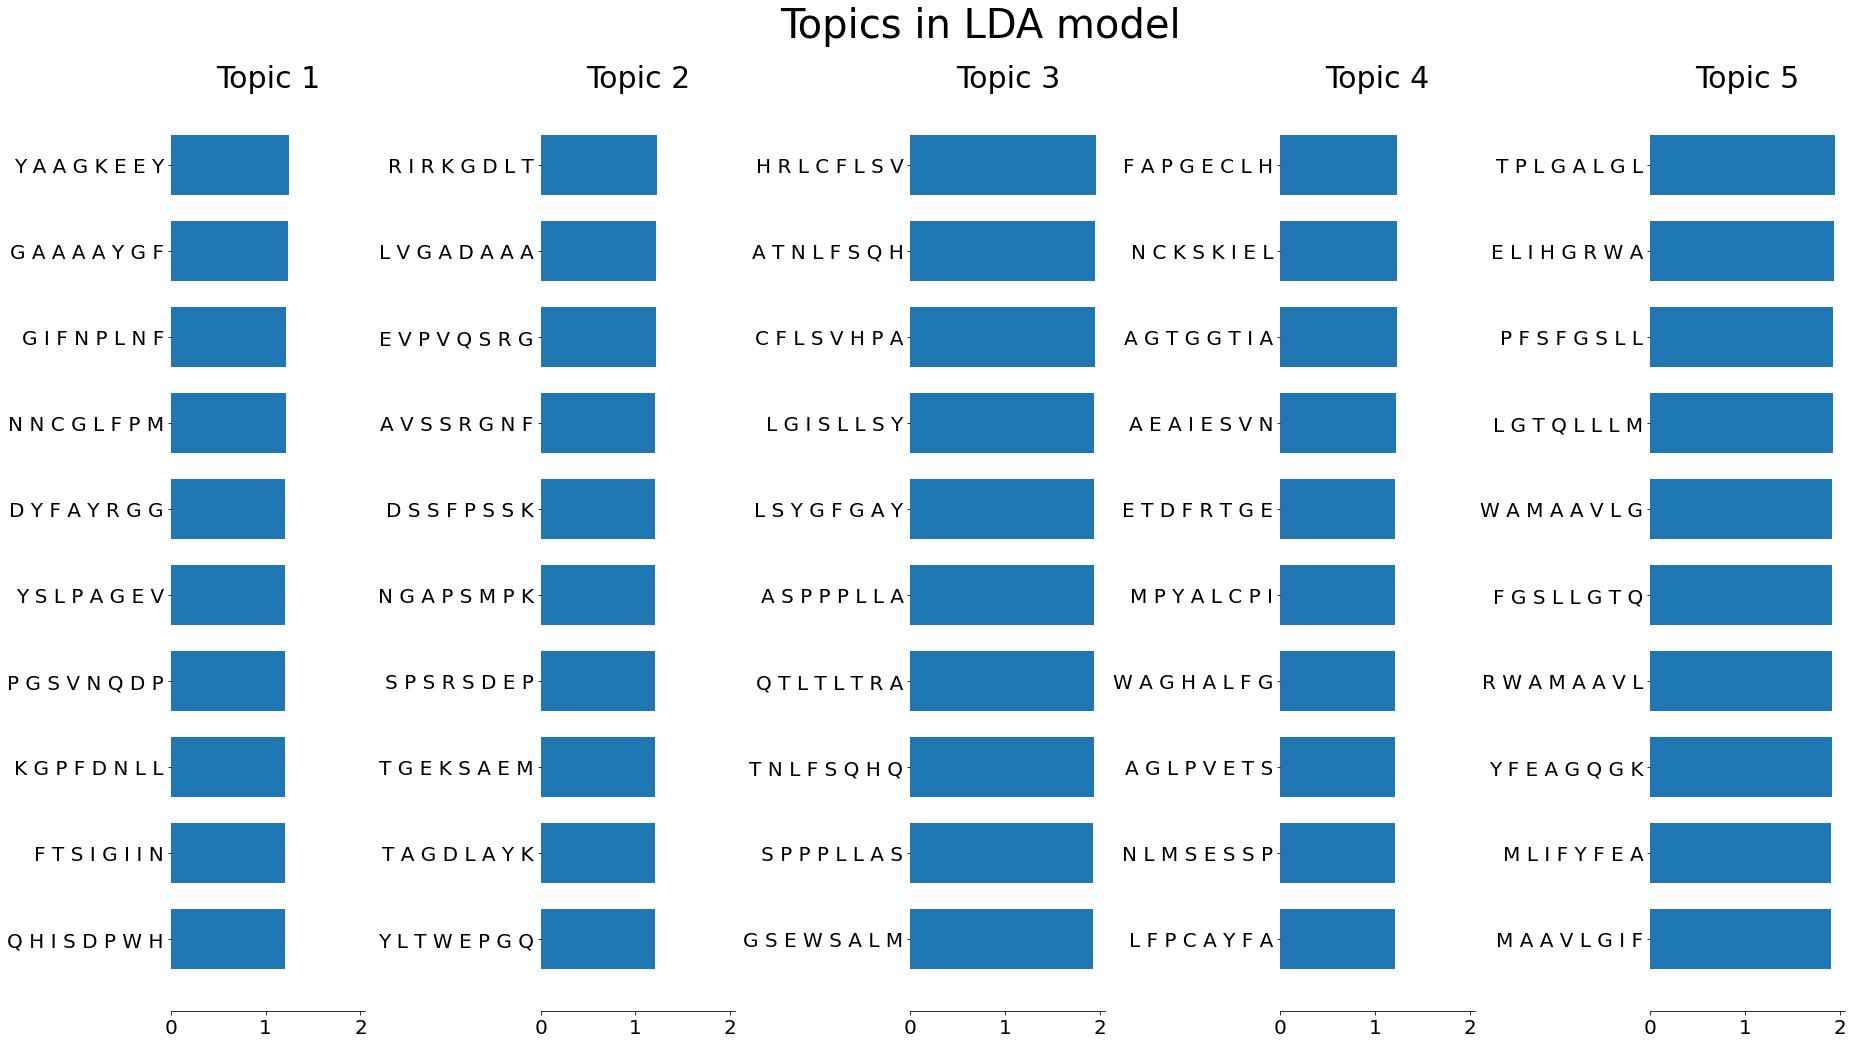




amino acid ngram range of study - (7, 7)
Extracting tf-idf features for NMF...
done in 0.039s.
Extracting tf features for LDA...
done in 0.030s.



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


done in 0.205s.


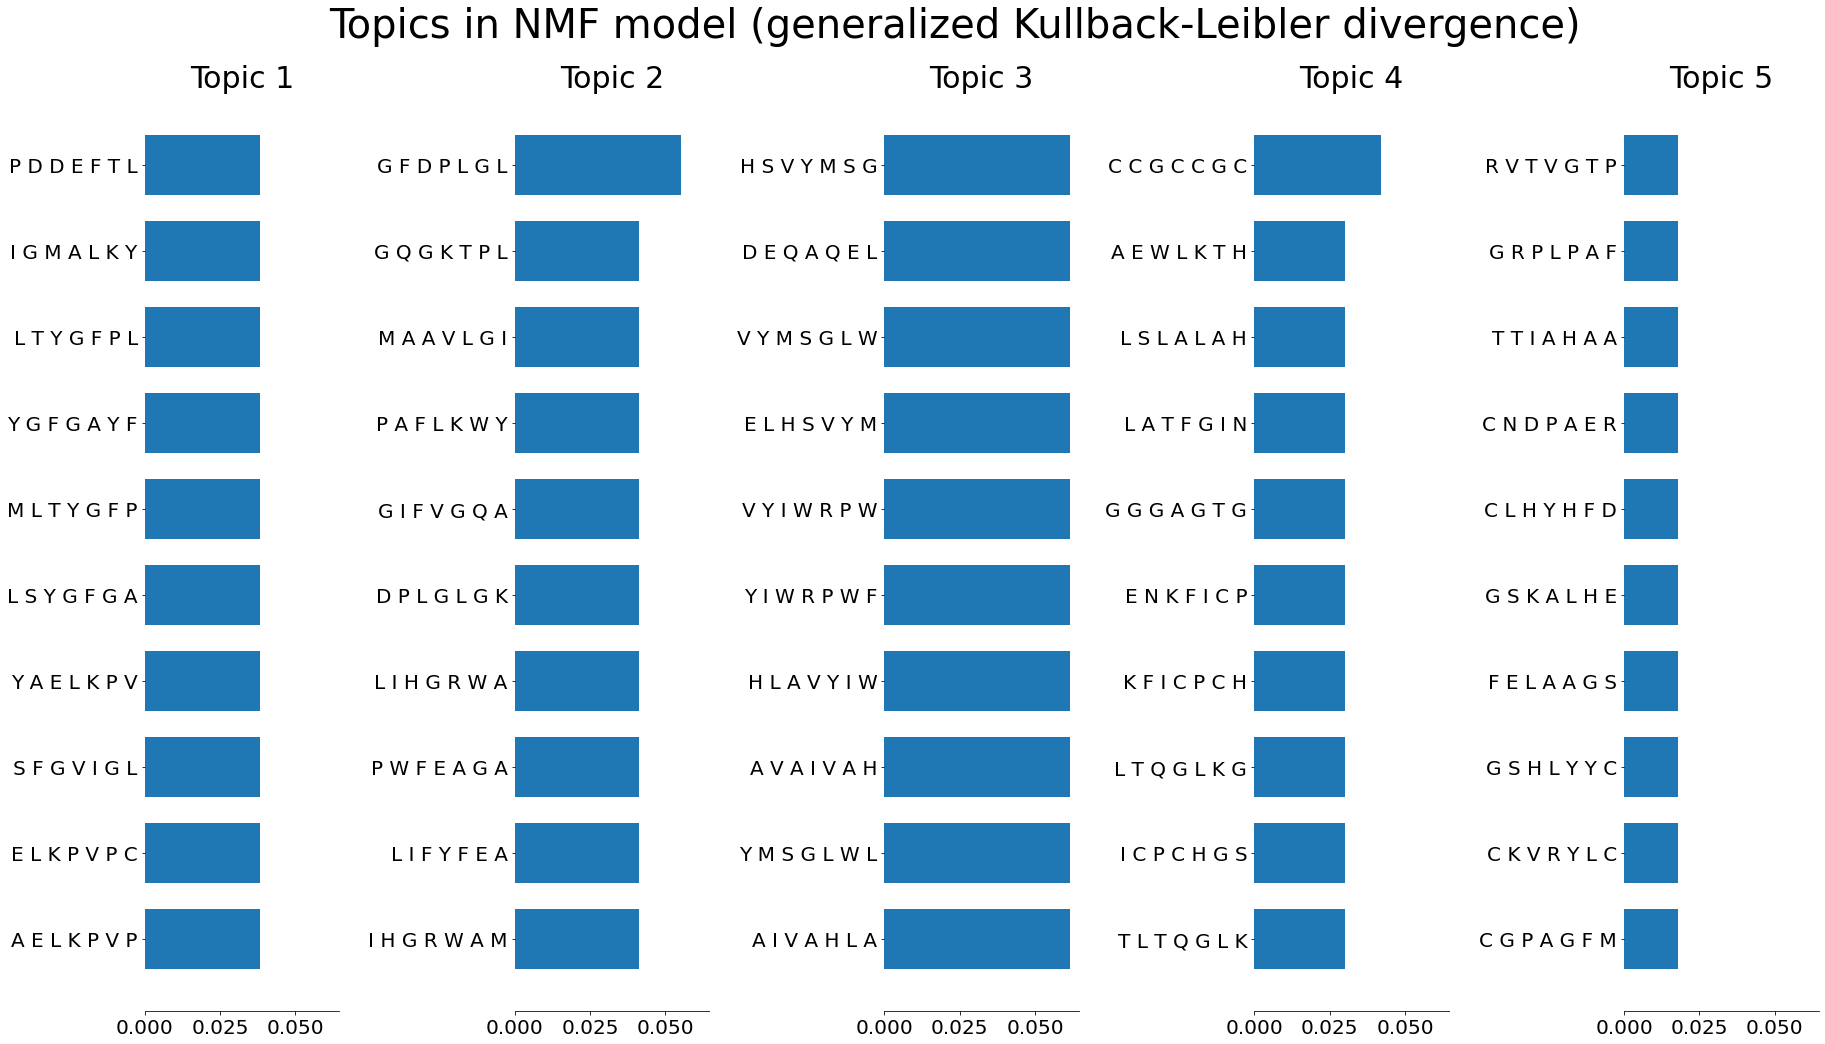



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


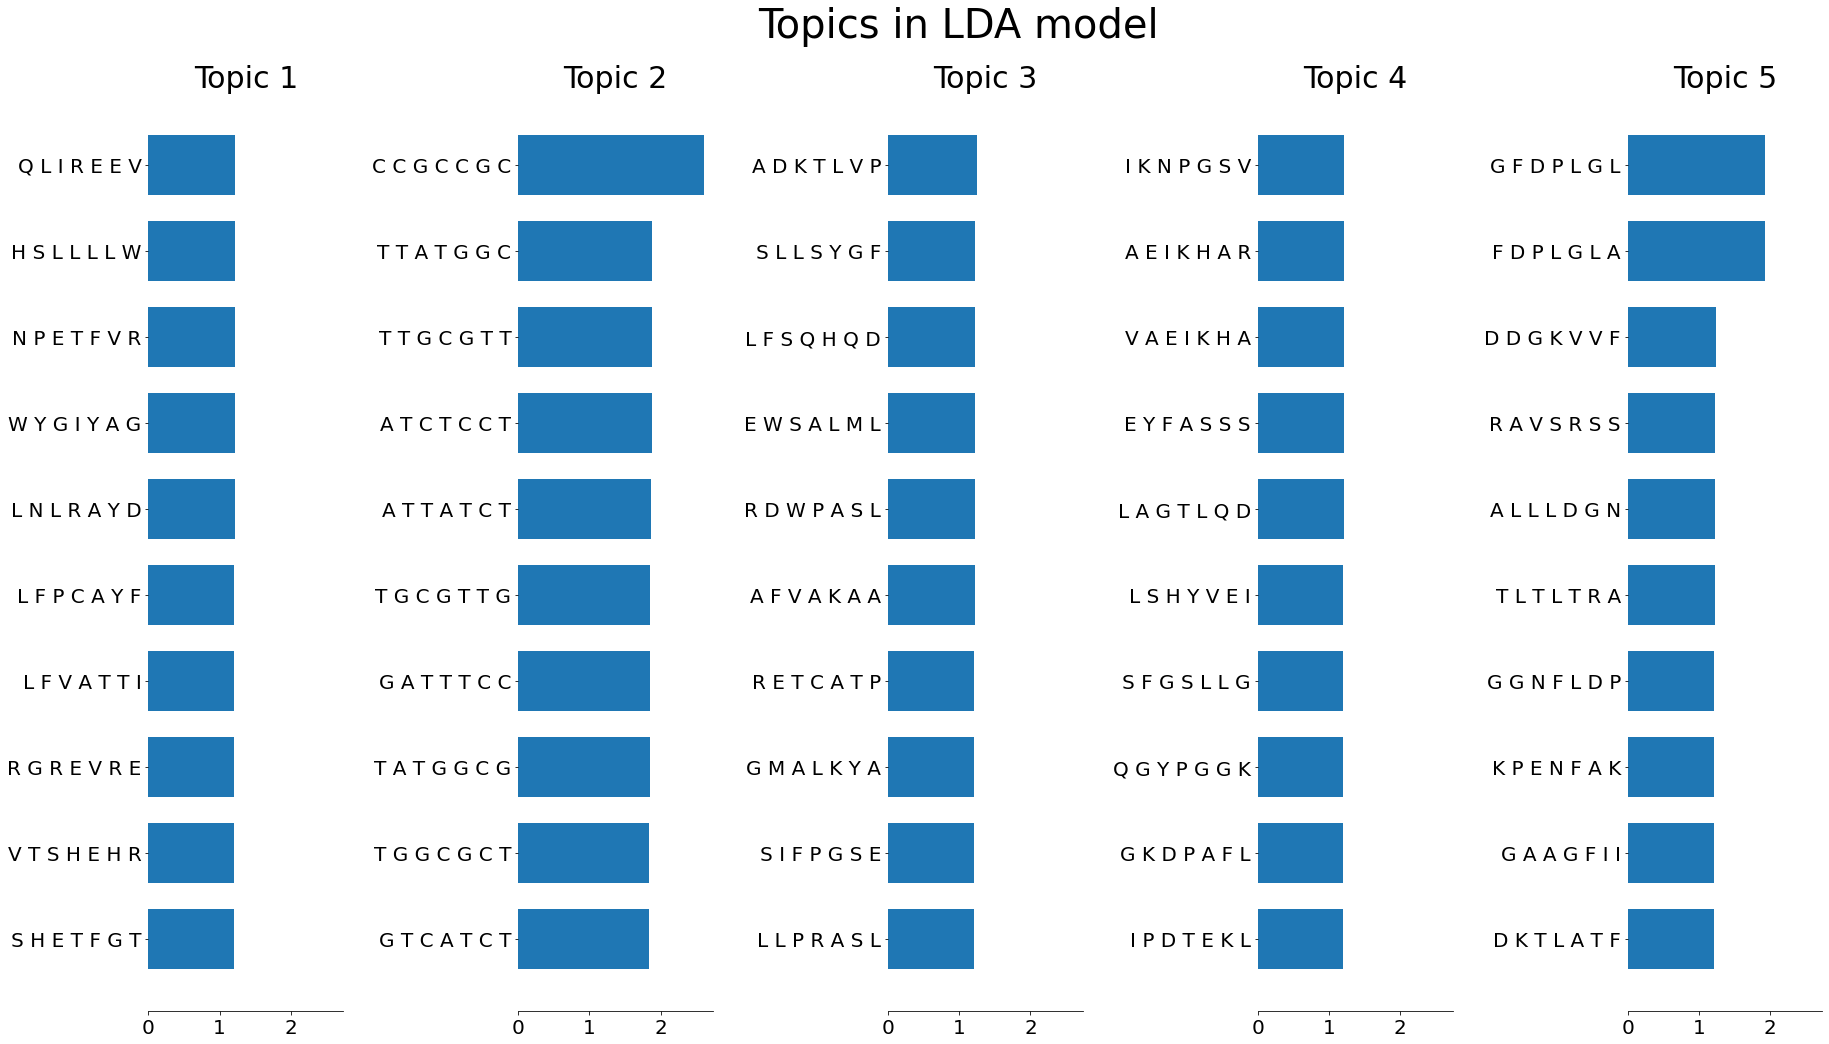




amino acid ngram range of study - (6, 6)
Extracting tf-idf features for NMF...
done in 0.046s.
Extracting tf features for LDA...
done in 0.083s.



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


done in 0.225s.


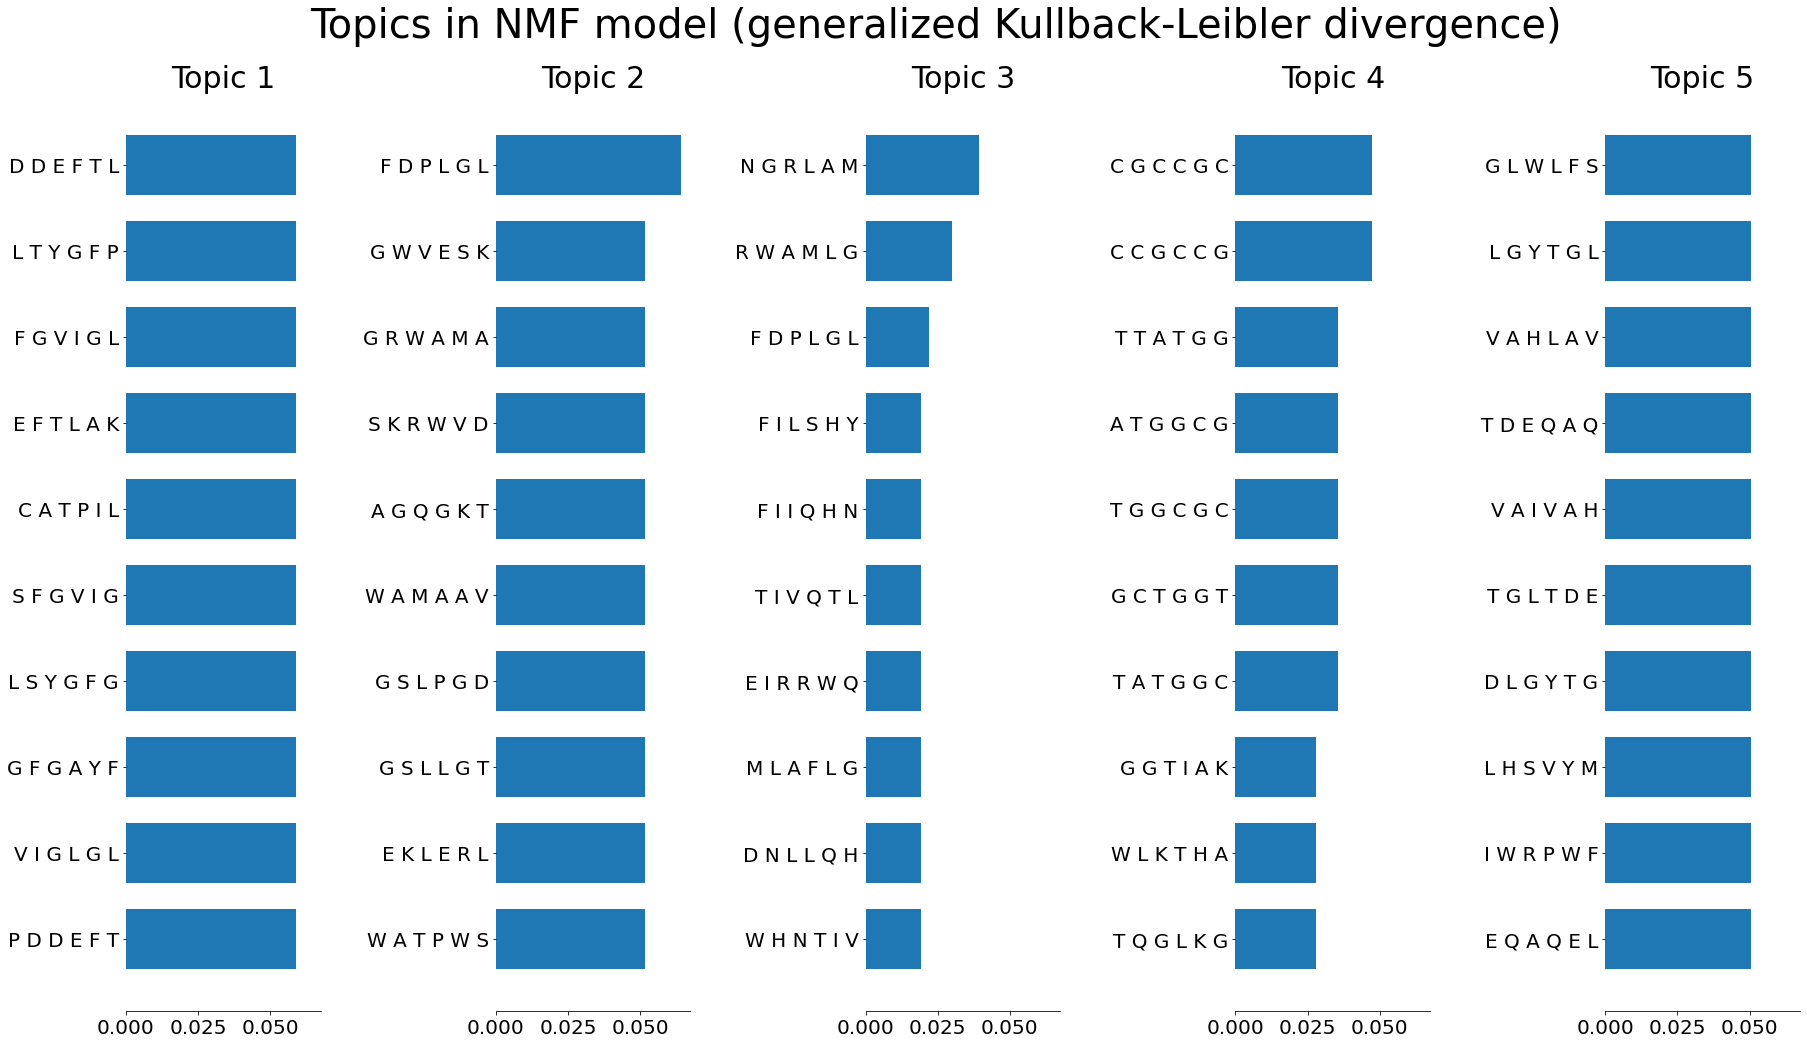



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


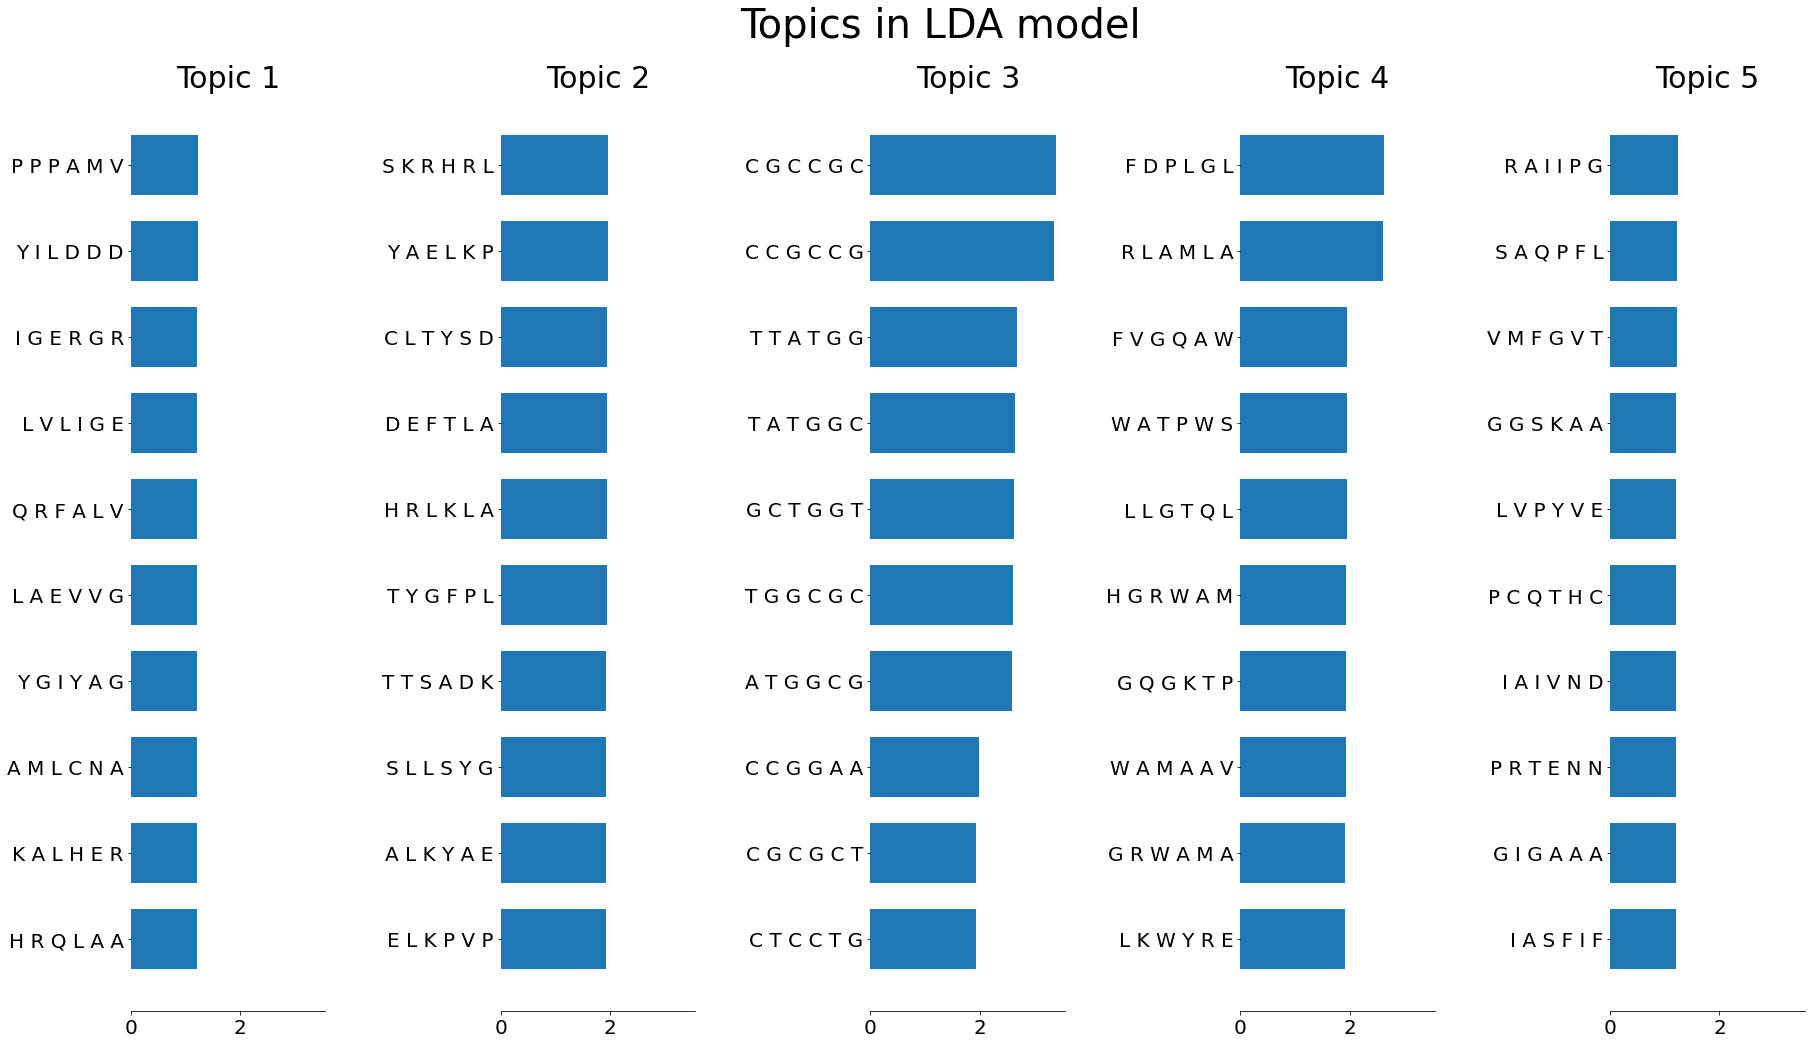




amino acid ngram range of study - (5, 5)
Extracting tf-idf features for NMF...
done in 0.030s.
Extracting tf features for LDA...
done in 0.022s.



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.151s.


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


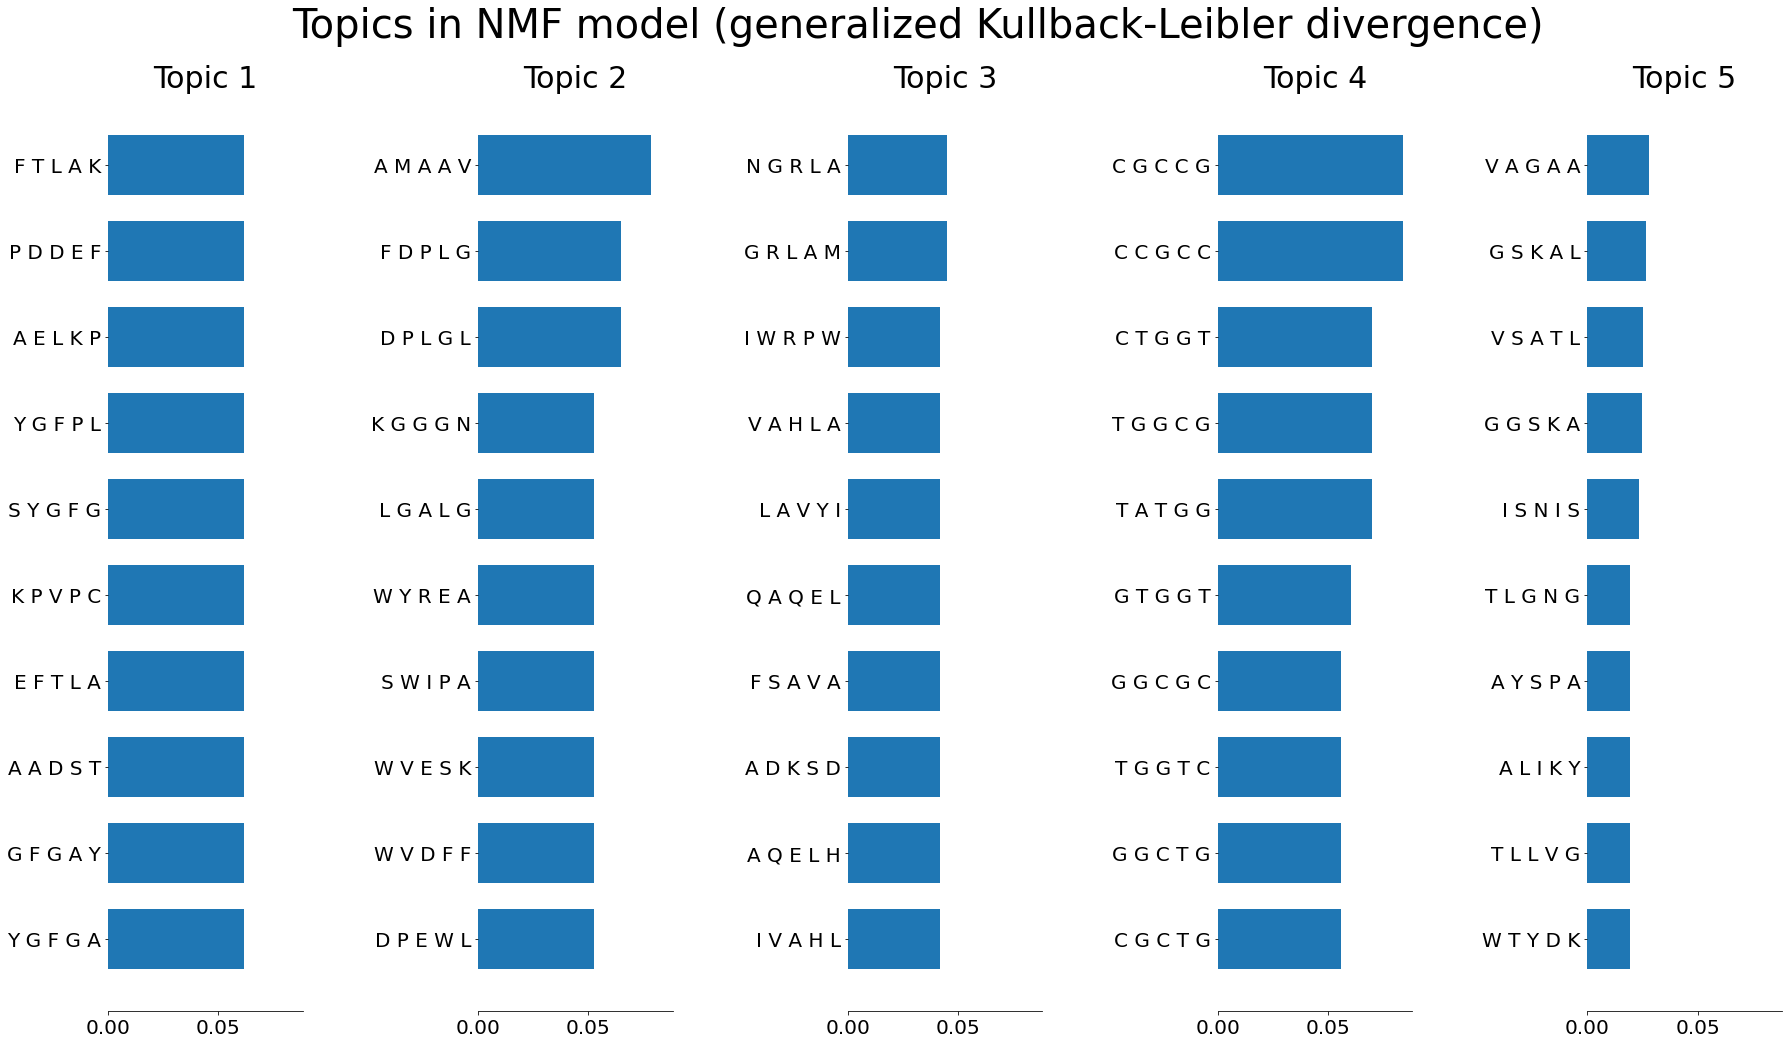



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


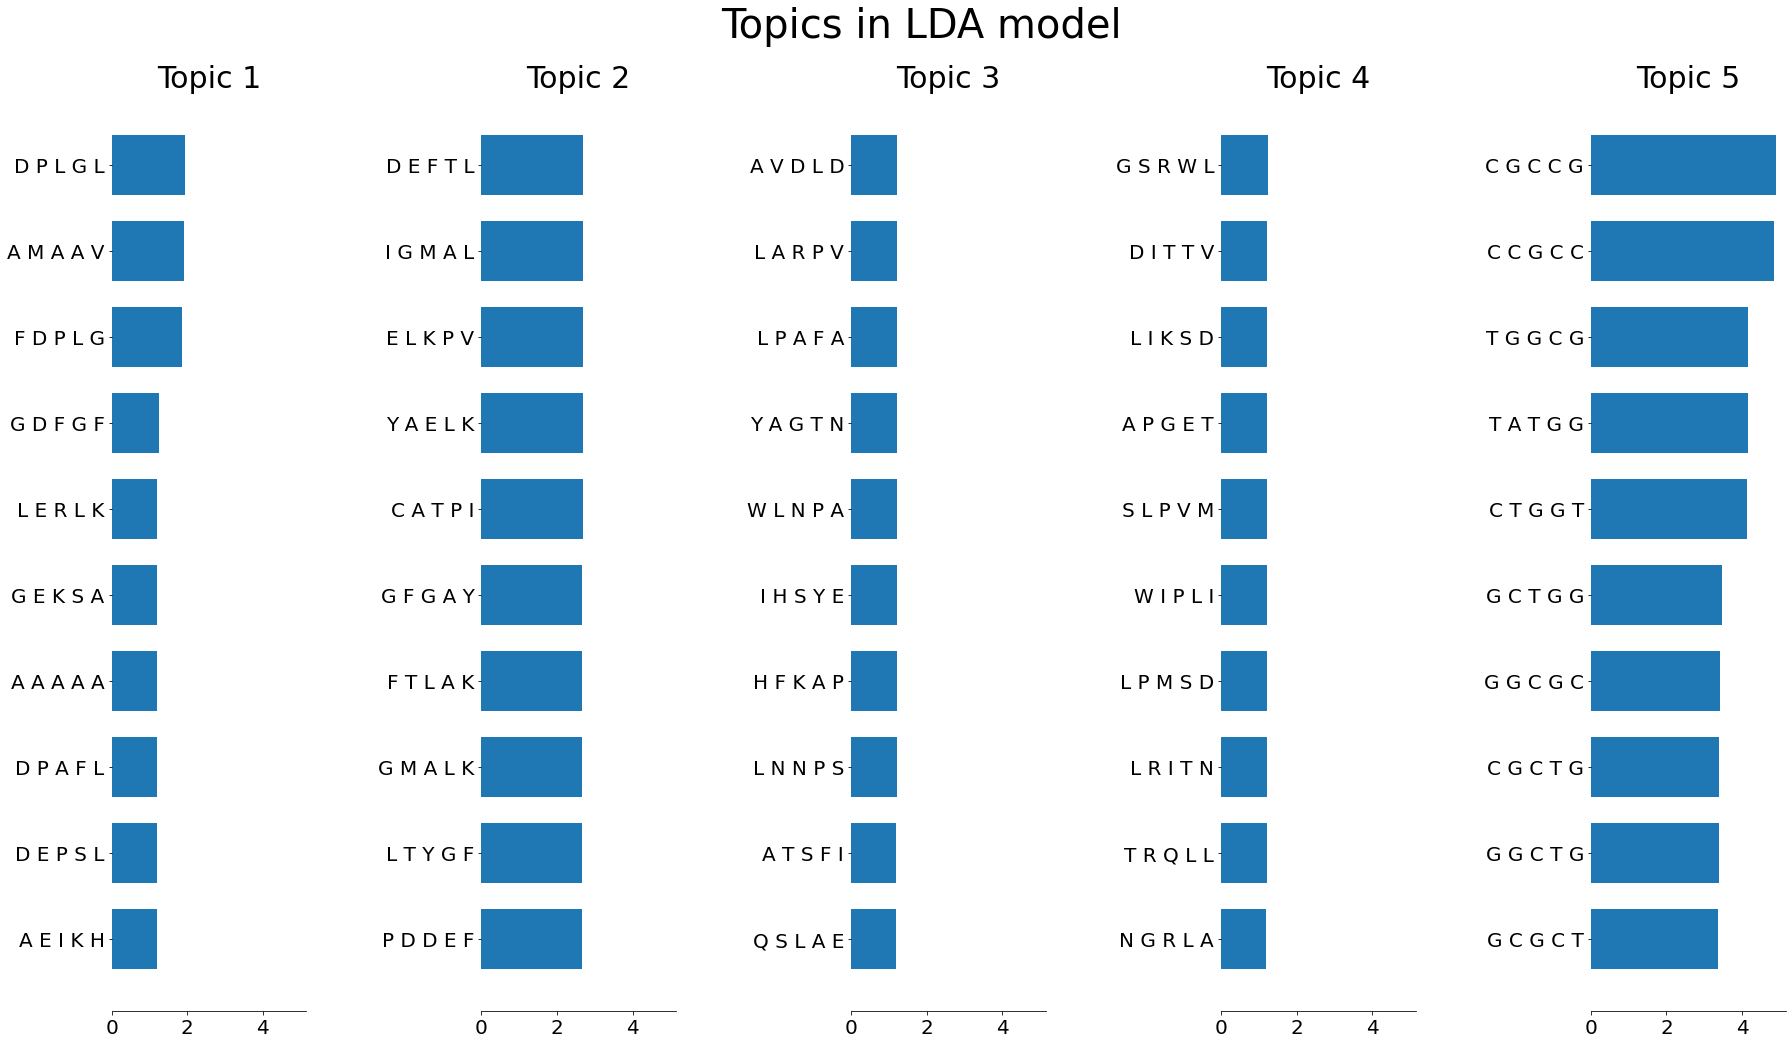




amino acid ngram range of study - (4, 4)
Extracting tf-idf features for NMF...
done in 0.028s.
Extracting tf features for LDA...
done in 0.018s.



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.118s.


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


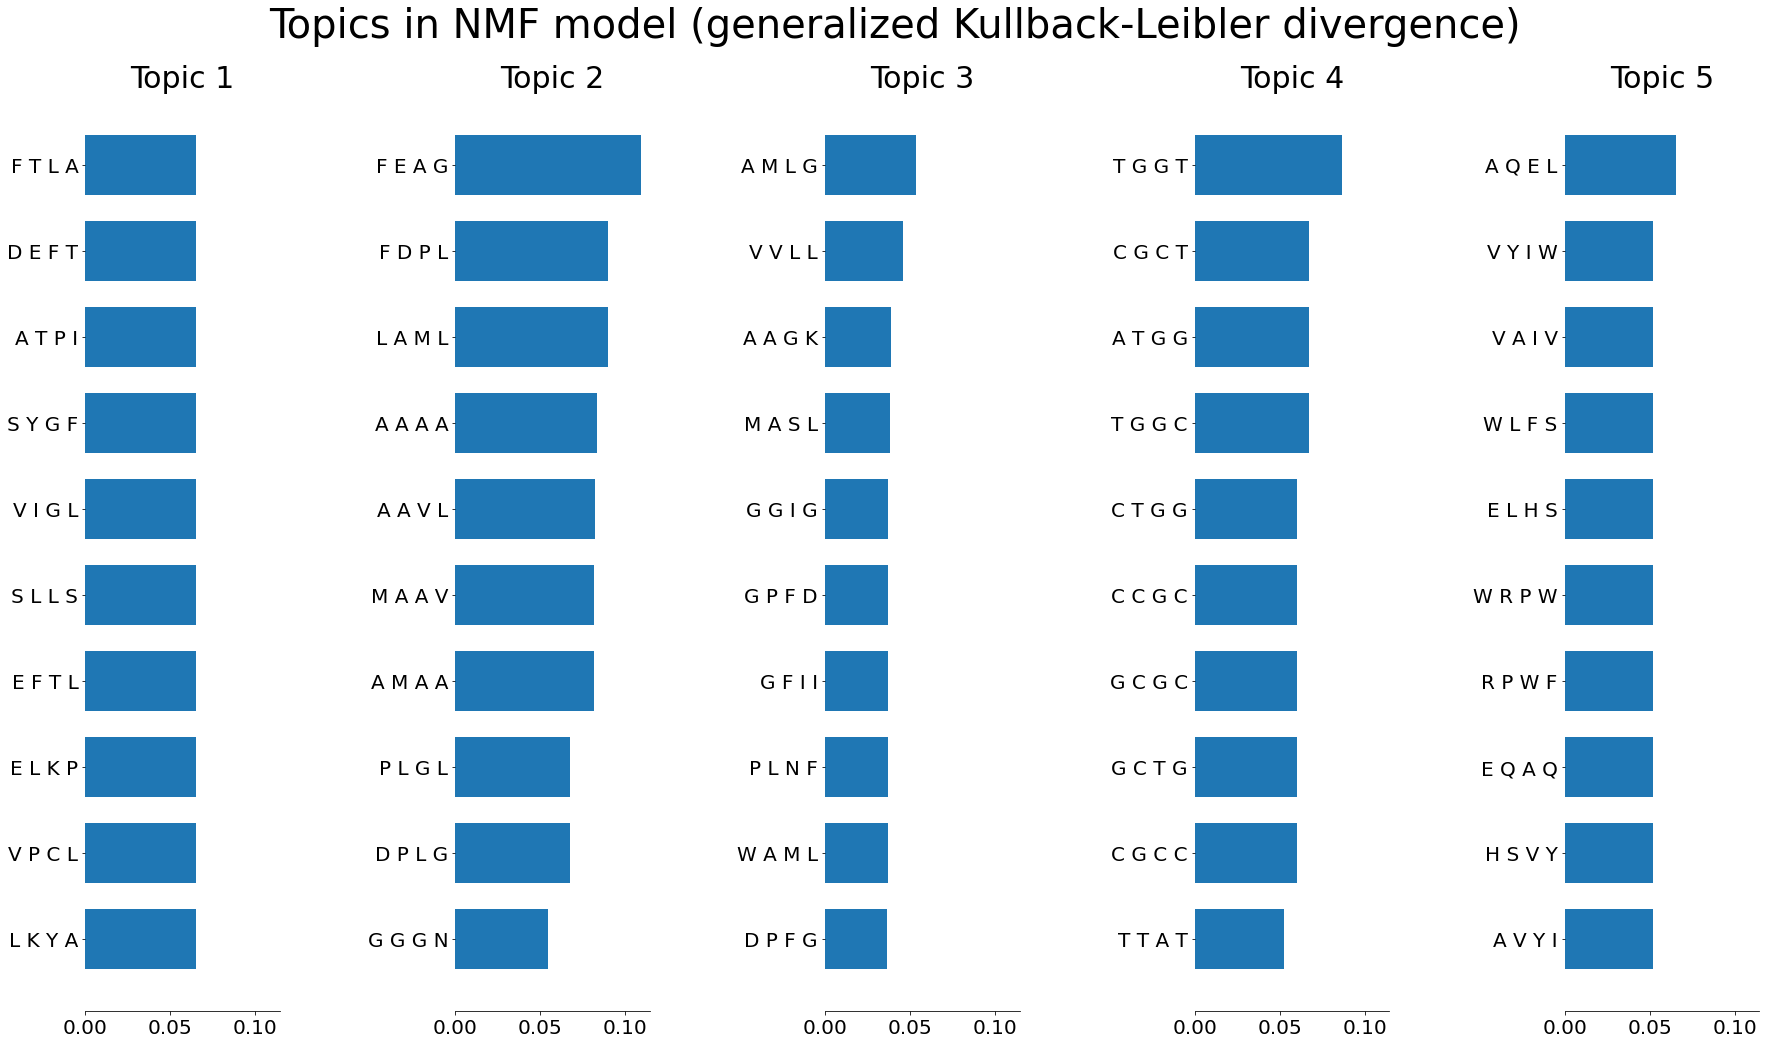



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


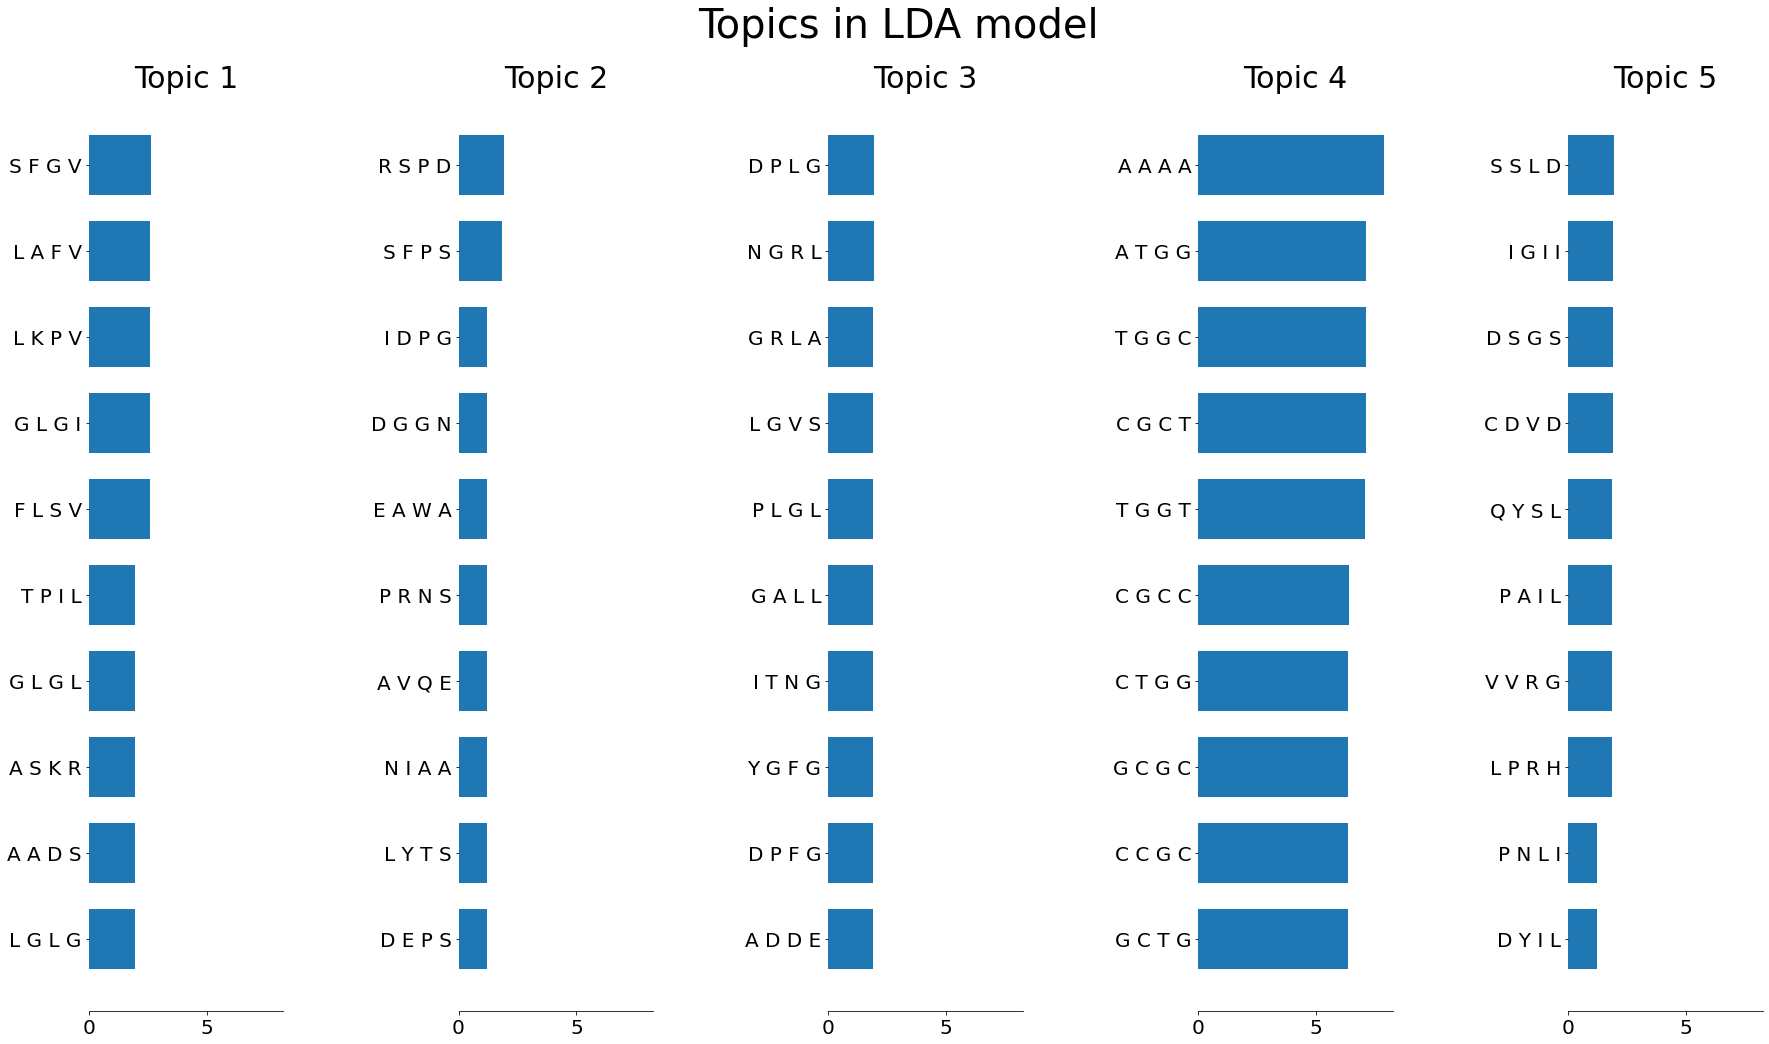




amino acid ngram range of study - (3, 3)
Extracting tf-idf features for NMF...
done in 0.018s.
Extracting tf features for LDA...
done in 0.022s.



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.117s.


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


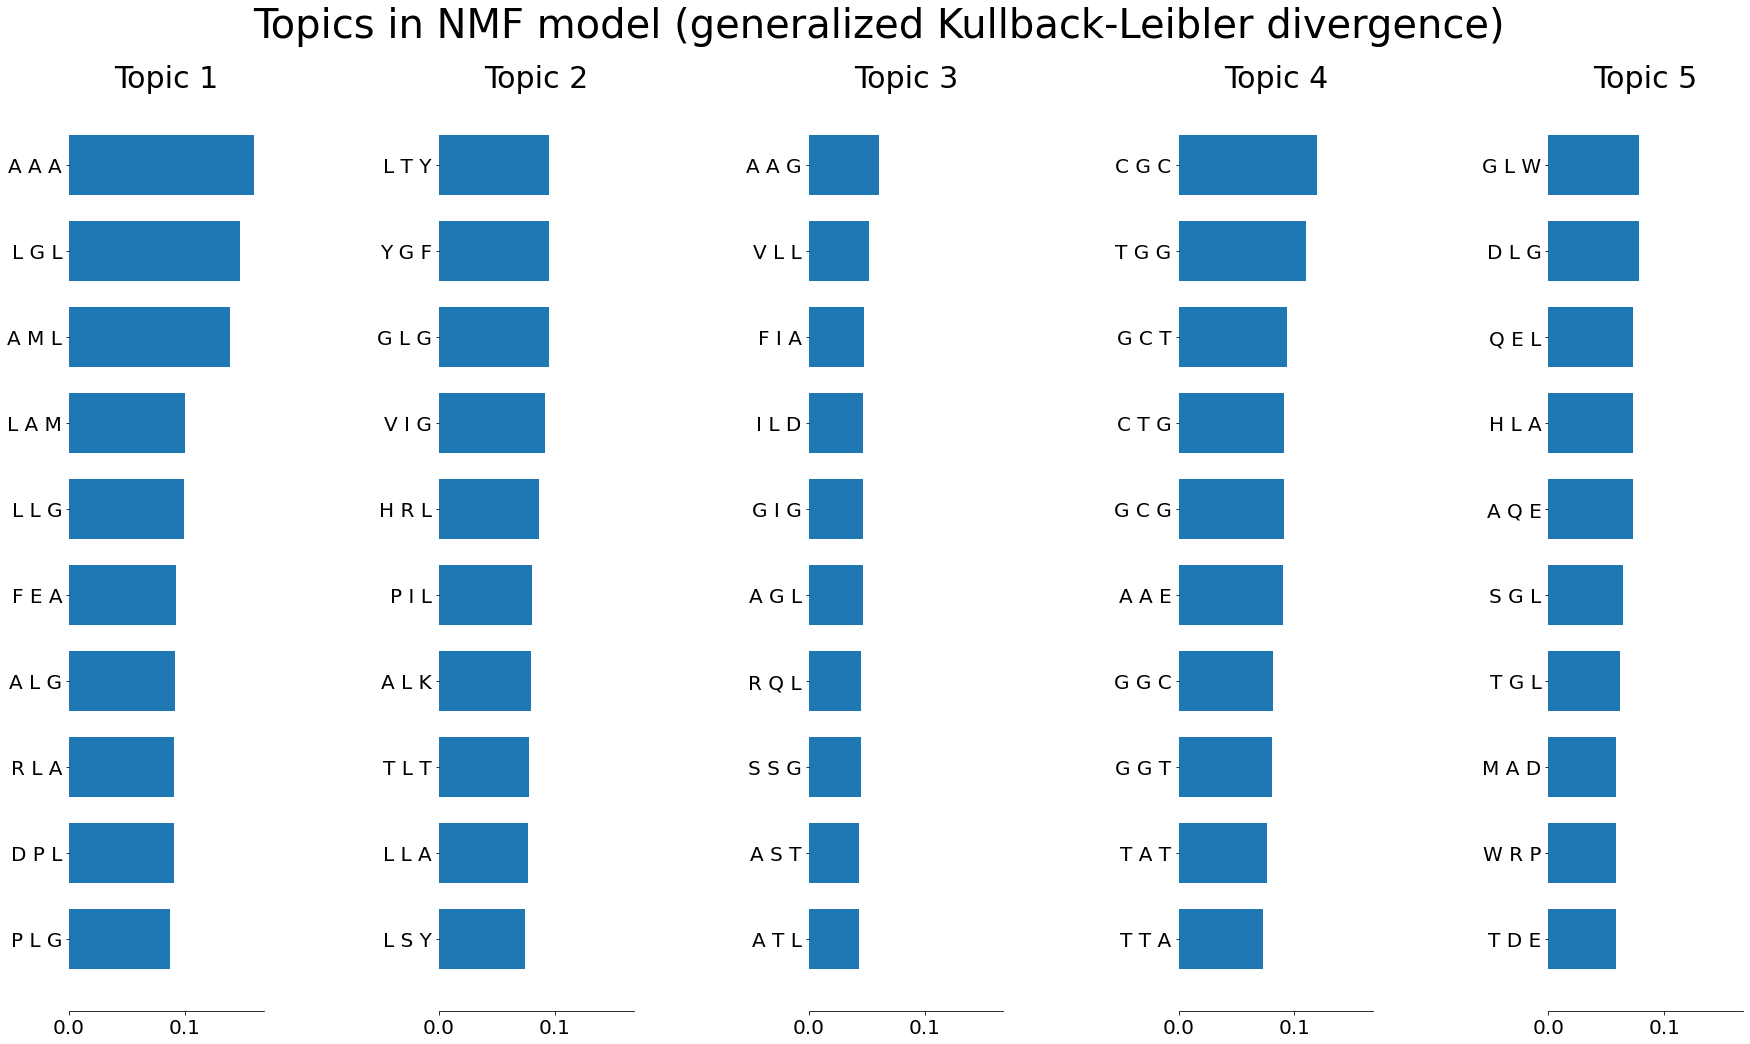



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


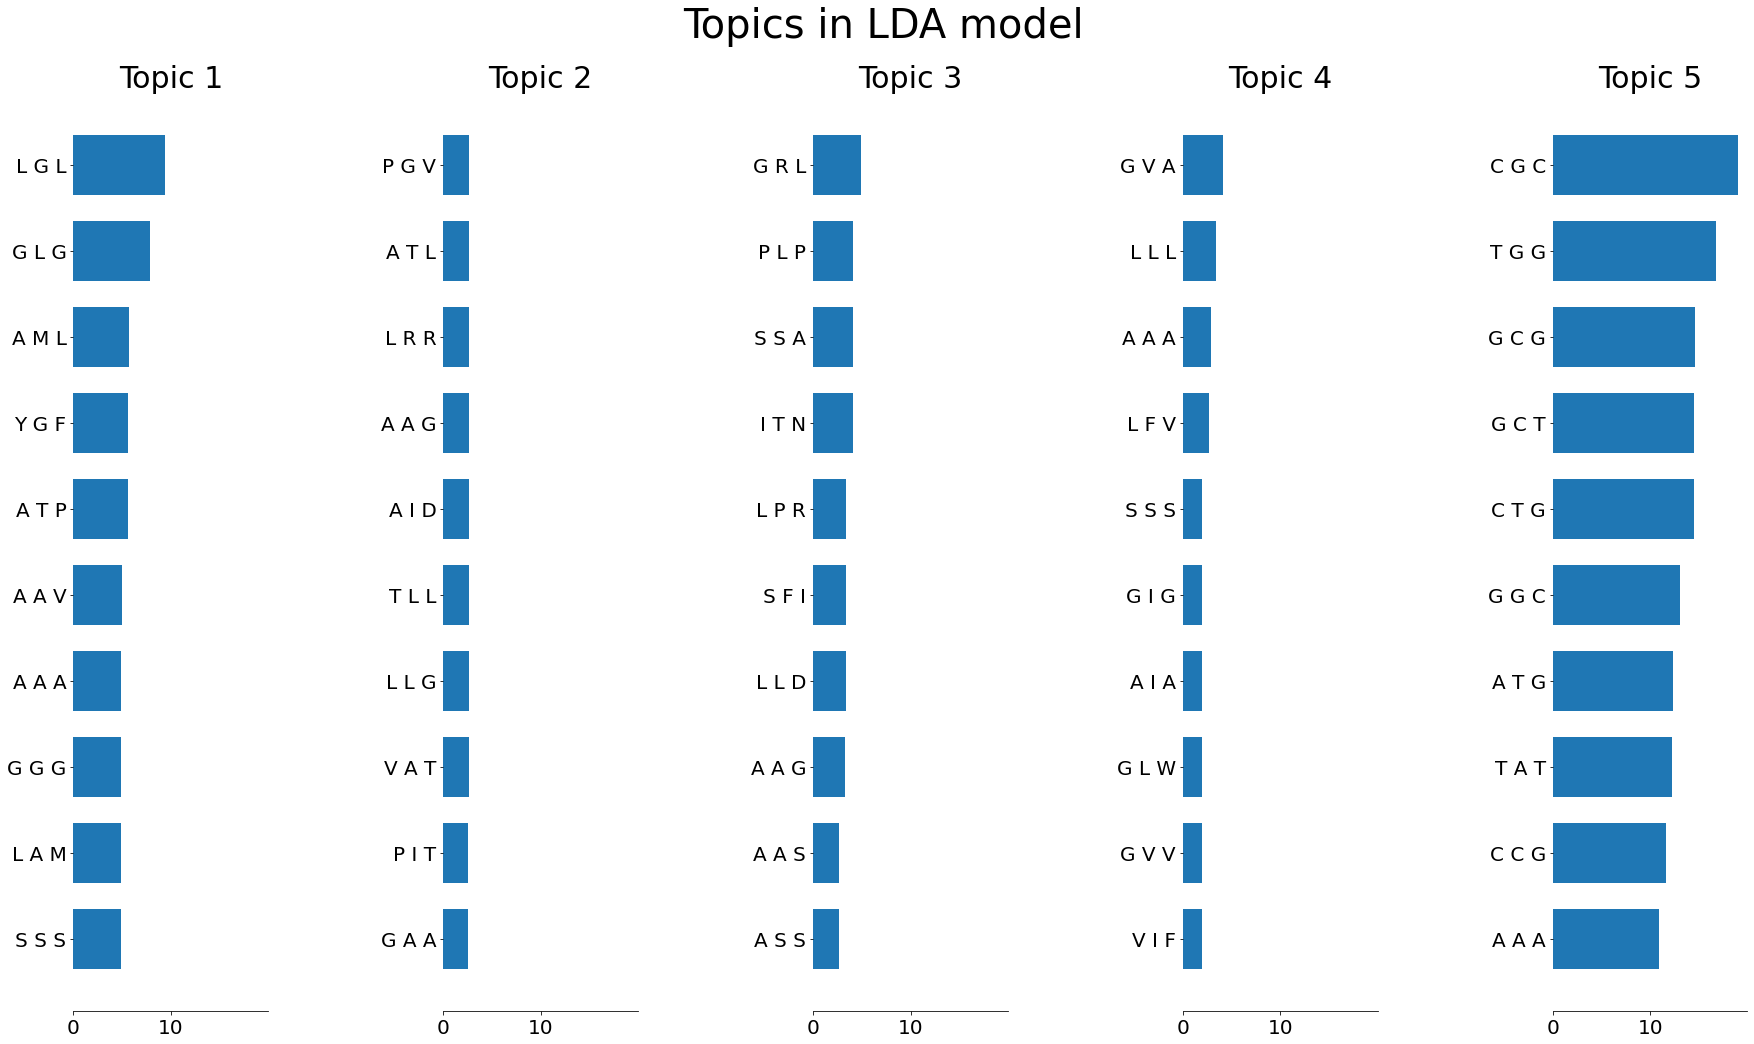




amino acid ngram range of study - (2, 2)
Extracting tf-idf features for NMF...
done in 0.013s.
Extracting tf features for LDA...
done in 0.011s.



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.143s.


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


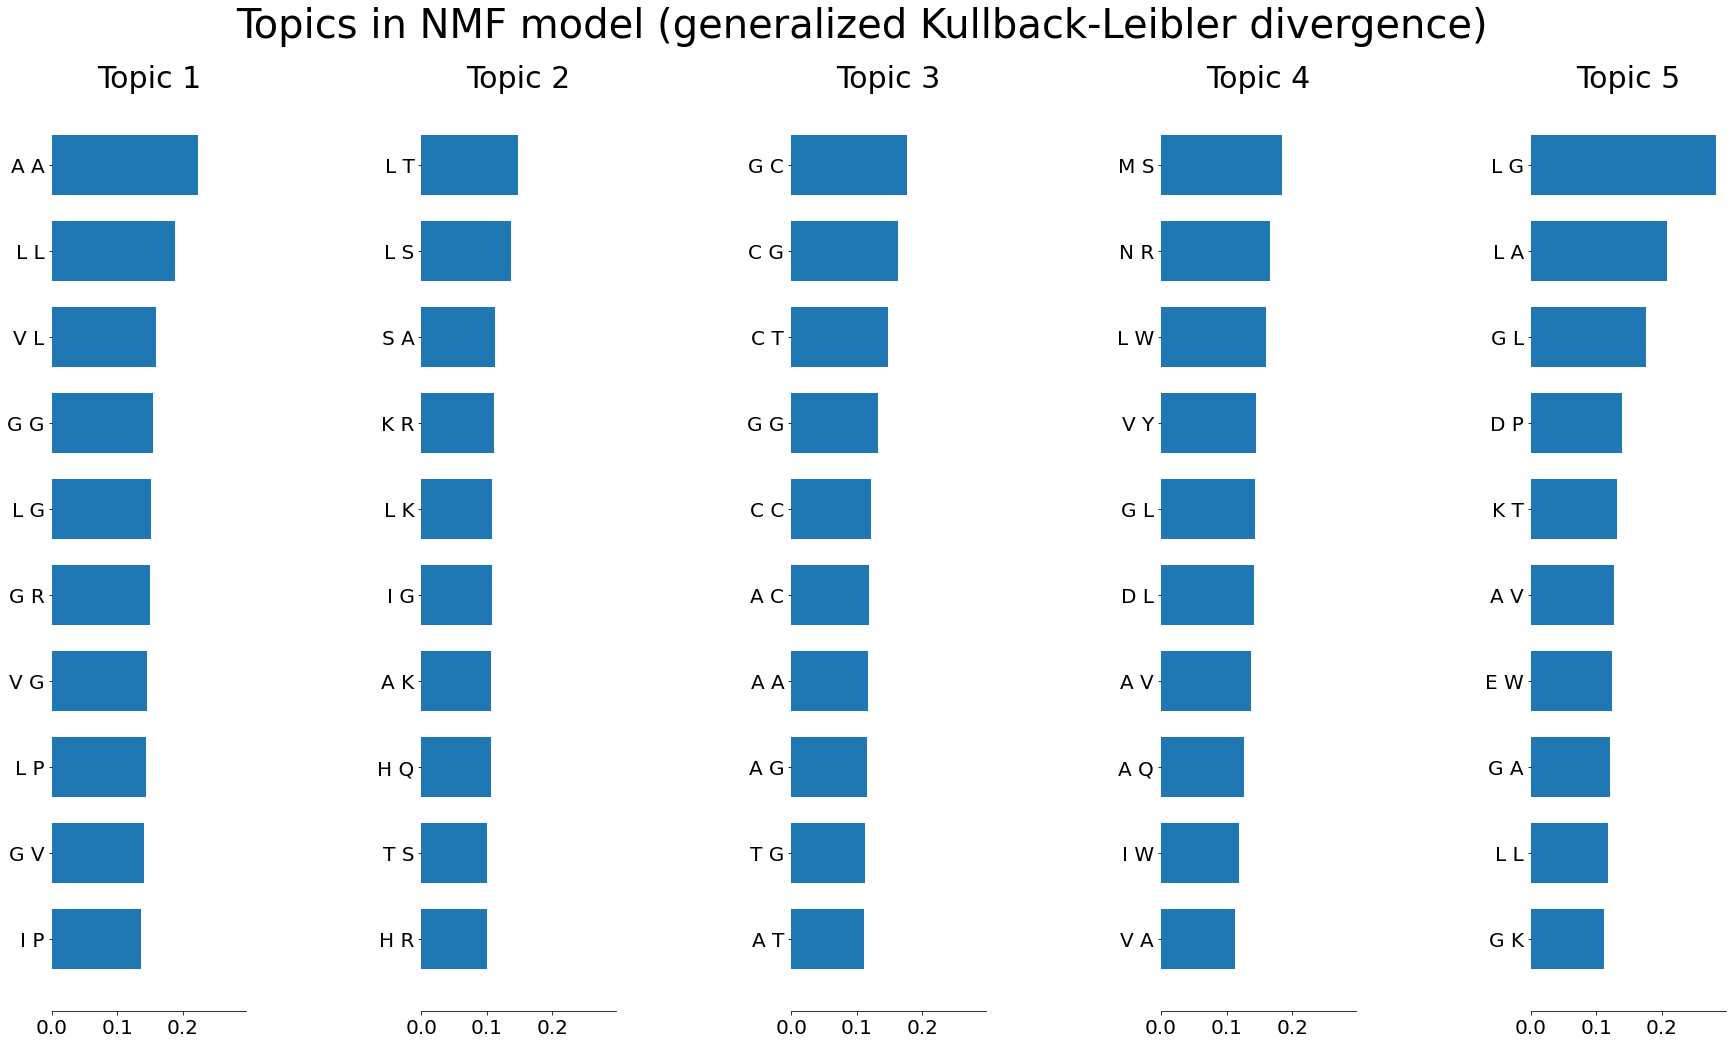



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


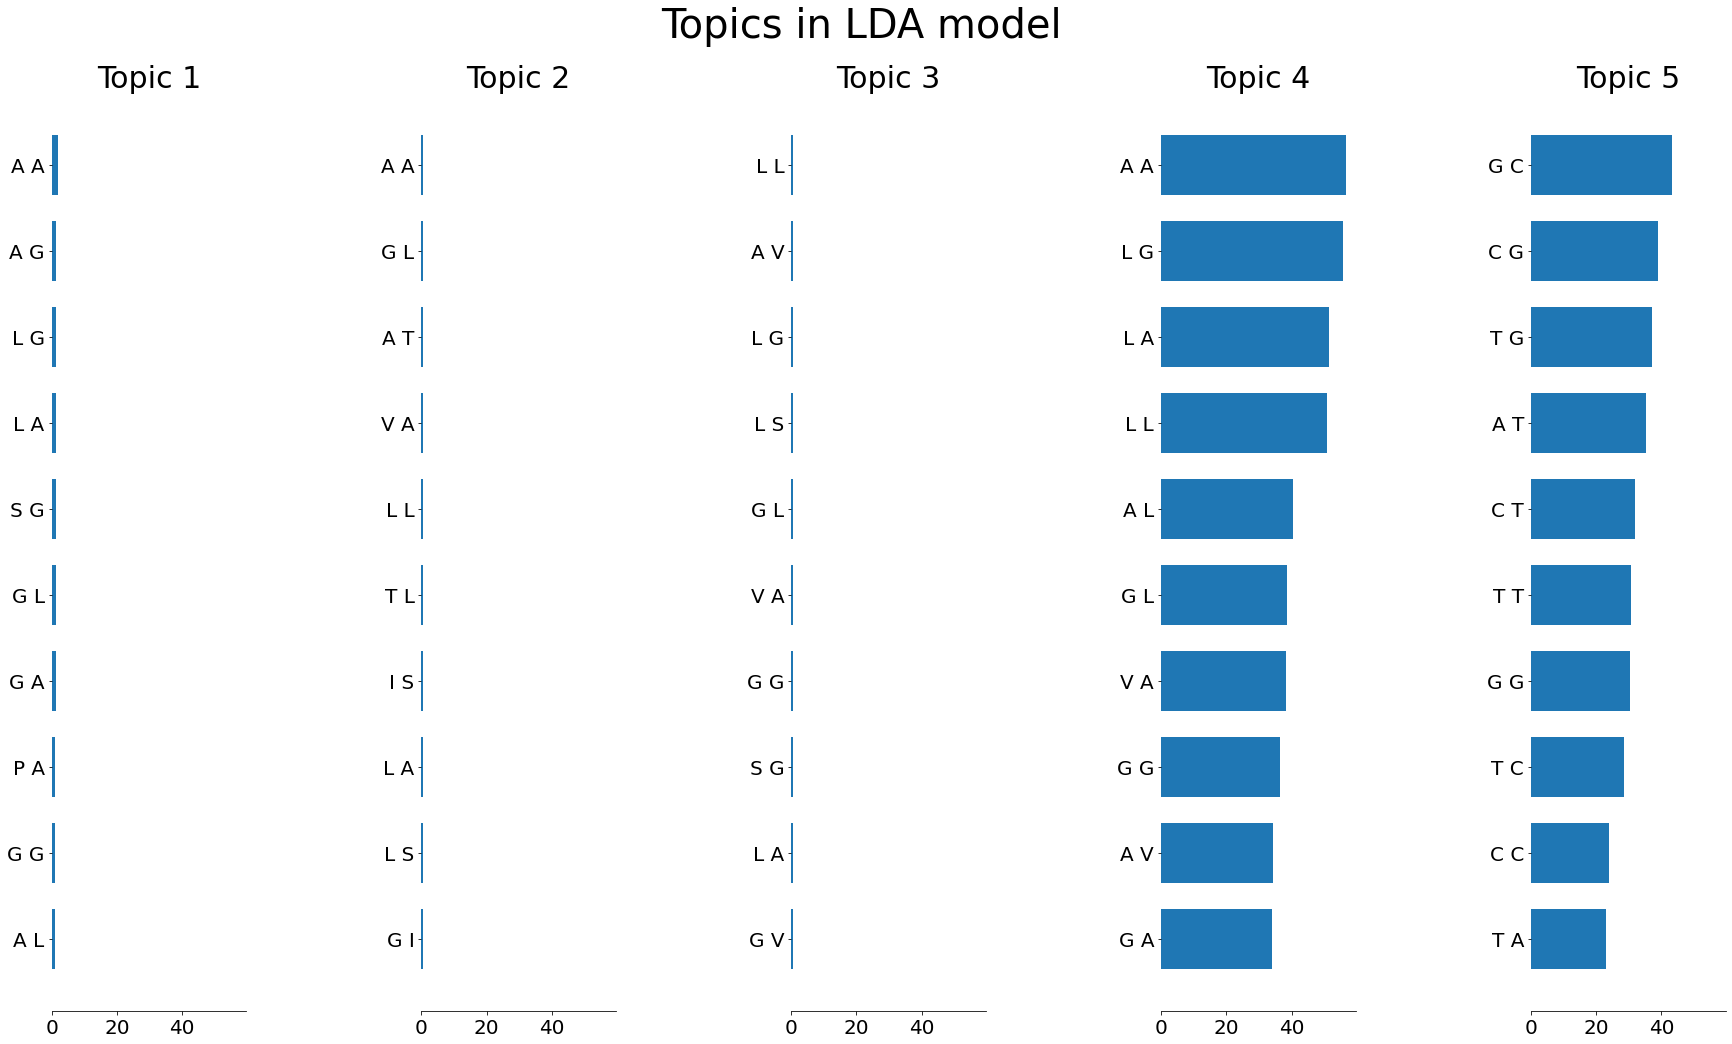




amino acid ngram range of study - (1, 1)
Extracting tf-idf features for NMF...
done in 0.007s.
Extracting tf features for LDA...
done in 0.007s.



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


done in 0.274s.


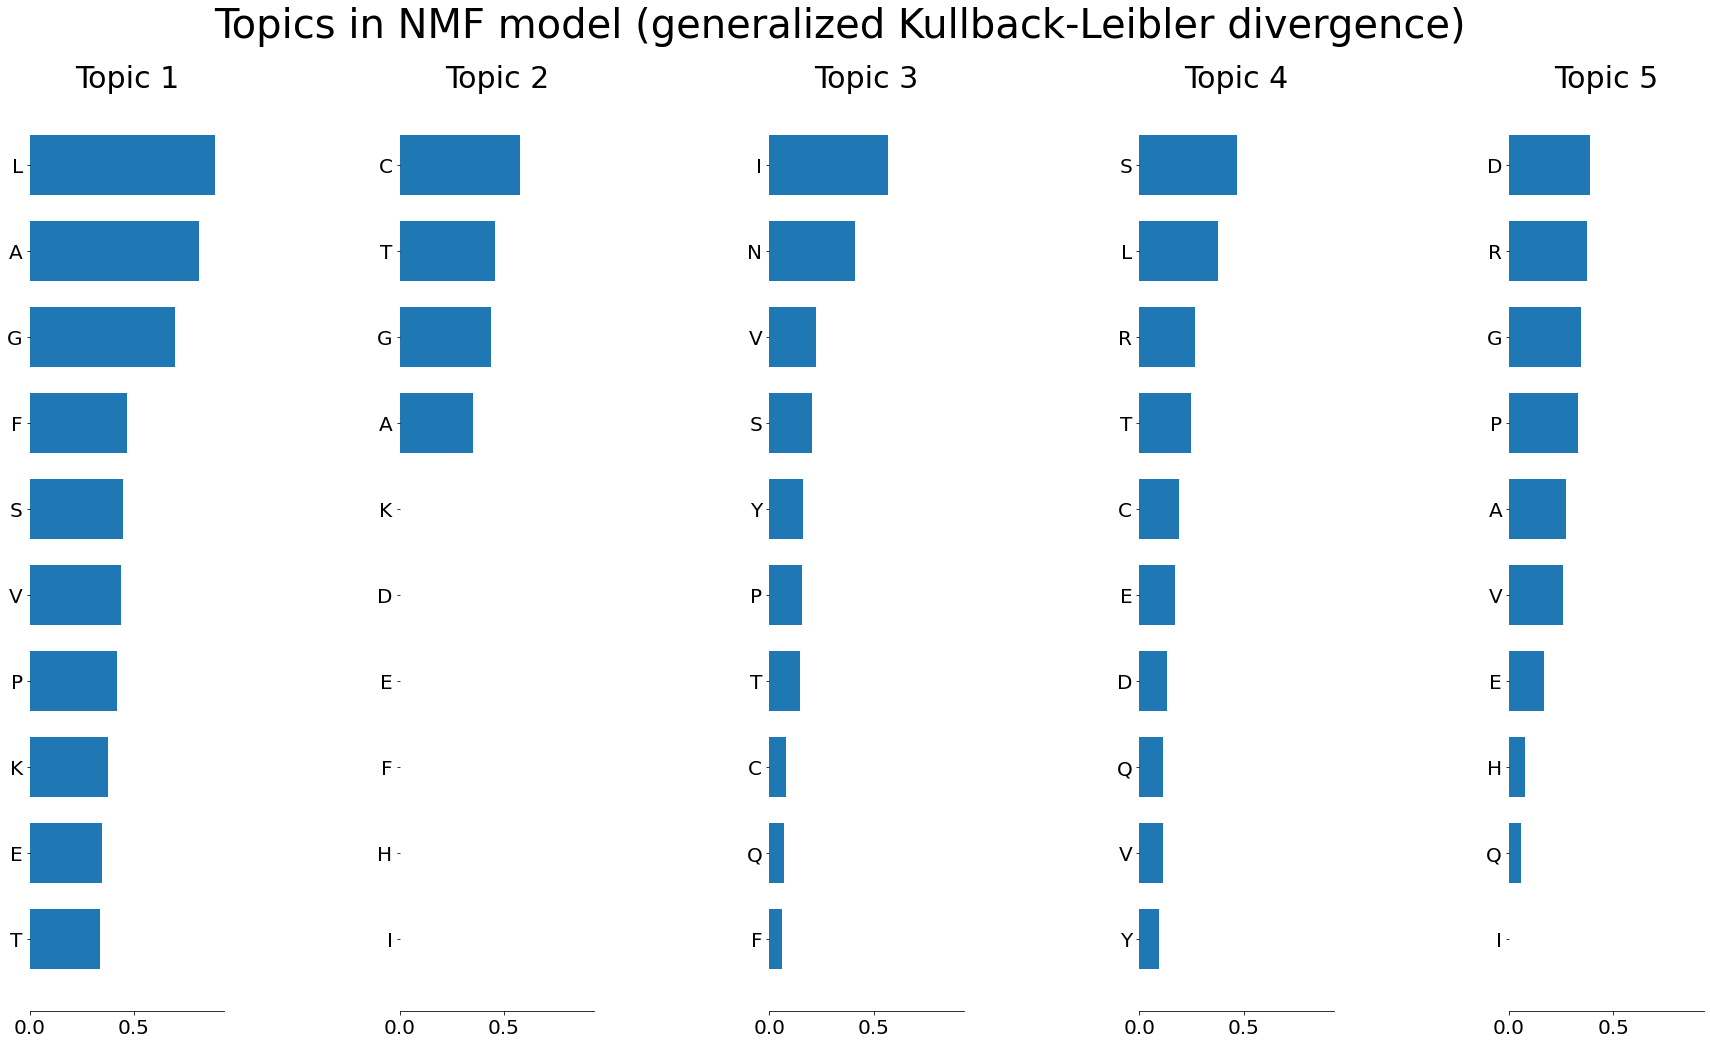



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


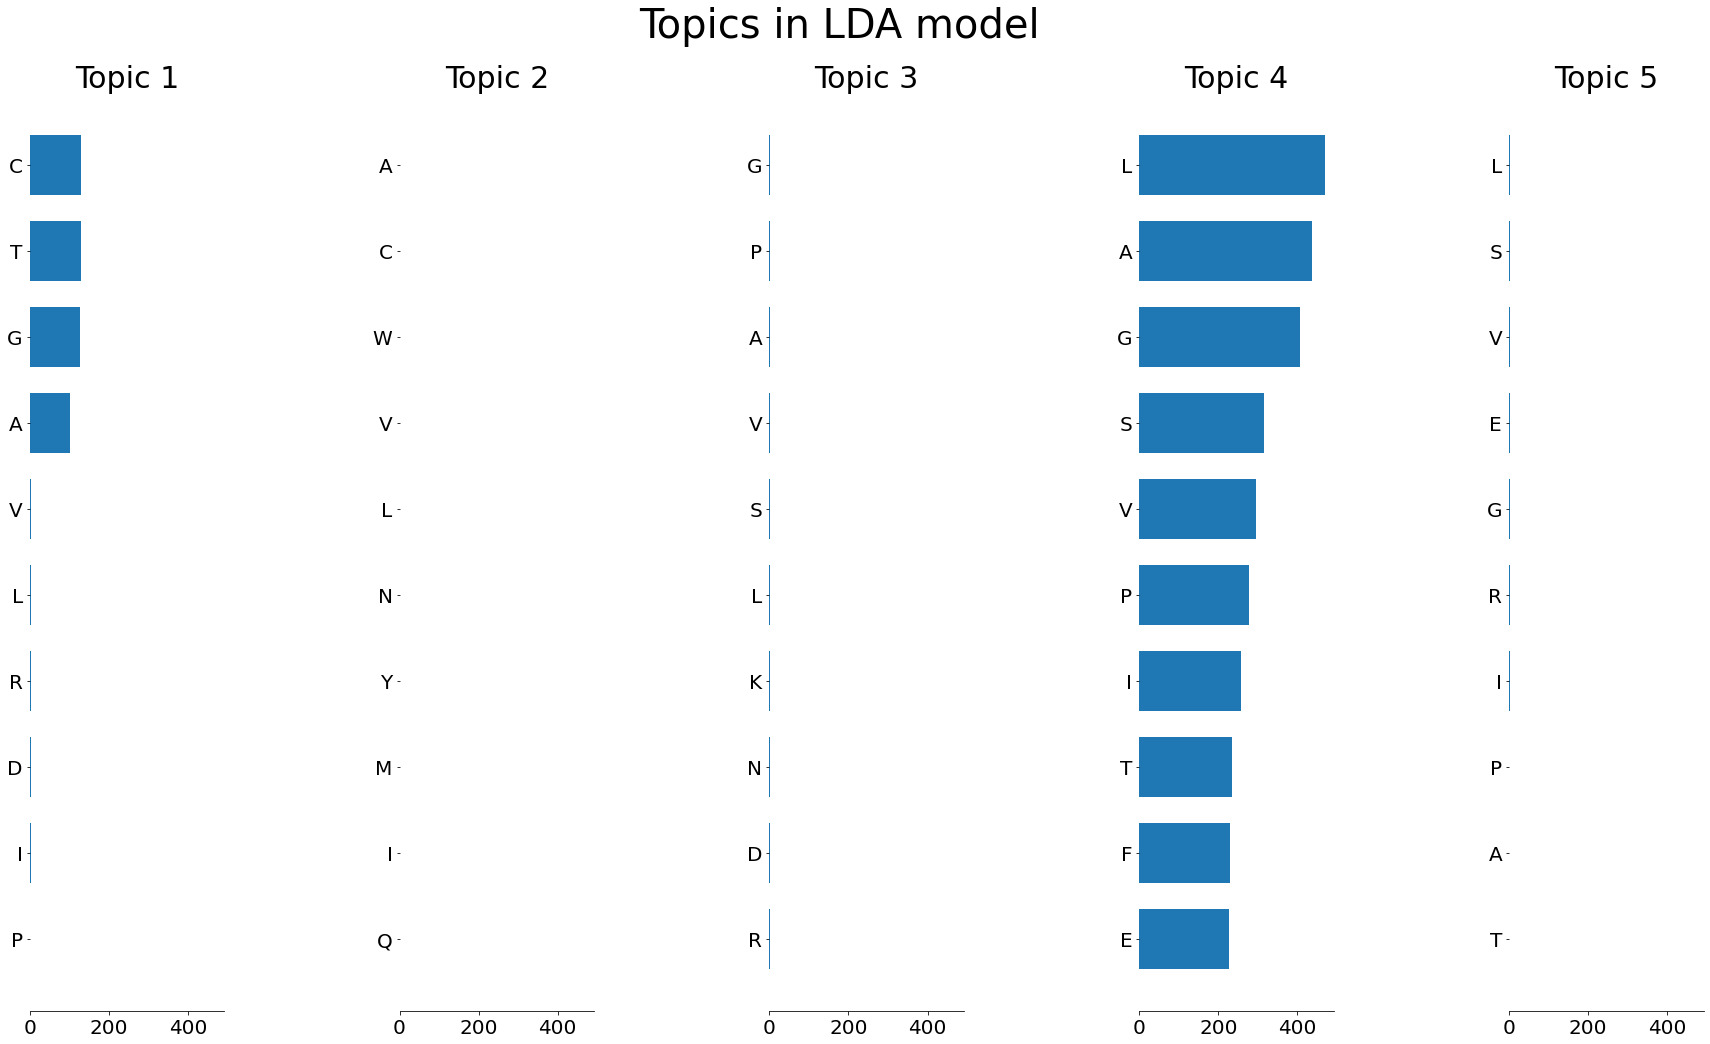

In [40]:
data_samples = df['protein split']
buf_df = pd.DataFrame()

for ngram_range_seed in ngram_ranges:

  # build ngram range tuple
  ngram_range = (ngram_range_seed, ngram_range_seed)
  print()
  print()
  print()
  print('amino acid ngram range of study - %s' % (ngram_range,))


# Use tf-idf features for NMF.
  print("Extracting tf-idf features for NMF...")
  tfidf_vectorizer = TfidfVectorizer(
                                  token_pattern='(?u)\\b\\w+\\b'
                                , lowercase=False
                                , ngram_range=ngram_range  
                                ,  
                                #    max_df=1
                                #  , min_df=2
                                #    max_features=n_features
                                #  , stop_words="english"
)
  t0 = time()
  tfidf = tfidf_vectorizer.fit_transform(data_samples)
  print("done in %0.3fs." % (time() - t0))

  # Use tf (raw term count) features for LDA.
  print("Extracting tf features for LDA...")
  tf_vectorizer = CountVectorizer(
                                    token_pattern='(?u)\\b\\w+\\b'
                                  , lowercase=False
                                  , ngram_range=ngram_range
                                  , 
                                  #    max_df=1
                                  #  , min_df=2
                                  #   max_features=n_features
                                  #  , stop_words="english"
  )
  t0 = time()
  tf = tf_vectorizer.fit_transform(data_samples)
  print("done in %0.3fs." % (time() - t0))
  print()


  # Fit the NMF model
  print(
      "\n" * 2,
      "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features),
  )
  t0 = time()
  nmf = NMF(
      n_components=n_components,
      random_state=1,
      beta_loss="kullback-leibler",
      solver="mu",
      max_iter=1000,
      alpha=0.1,
      l1_ratio=0.5,
  ).fit(tfidf)
  print("done in %0.3fs." % (time() - t0))

  tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
  dfff = plot_top_words(
      nmf,
      tfidf_feature_names,
      n_top_words,
      "Topics in NMF model (generalized Kullback-Leibler divergence)"
  )

  dfff['model'] = 'nmf'
  dfff['ngram_seed'] = ngram_range_seed
  buf_df = pd.concat([buf_df, dfff])

  print(
      "\n" * 2,
      "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features),
  )
  lda = LatentDirichletAllocation(
      n_components=n_components,
      max_iter=25,
      learning_method="online",
      learning_offset=50.0,
      random_state=0,
  )

  lda.fit(tf)

  tf_feature_names = tf_vectorizer.get_feature_names_out()
  dff = plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

  dff['model'] = 'lda'
  dff['ngram_seed'] = ngram_range_seed
  buf_df = pd.concat([buf_df, dff])

In [41]:
# prime structure with input sequences
higher_order_sequence = df['protein split']
buff_df = pd.DataFrame()
graph_lst = []
graph_node_lst = []
graph_specific_node_lst = []

# for each latent representative
for md in ['lda', 'nmf']:

  # for each range of amino acid / peptide n-grams
  for ngram_range_seed in ngram_ranges:

    # reset buffer at each ngram
    buf_lst = []

    # for each combination of sequence length and model
    df_slice = buf_df[buf_df['ngram_seed'] == ngram_range_seed]
    df_slice = df_slice[df_slice['model'] == md]

    # for each cluster of peptide / acids
    rw = 0
    for cluster in range(1, n_components):

      peptide_node = f"Topic_{cluster}_node"
      peptide_specific_node = f"{ngram_range_seed}_Seq_Topic_{cluster}_node"
      peptide_weight = f"Topic_{cluster}_weight"

      # for each combination of cluster and ngram peptide
      for scenerio in range(0, len(peptide_node)):
      
        # envoke pods
        try:

          # dont return to much info
          if len(df_slice[peptide_node][scenerio]) > 2:

            print('%s Model - Topic - %d Node - %s Weight %s' % ( md
                                                                , cluster
                                                                , df_slice[peptide_node][scenerio]
                                                                , df_slice[peptide_weight][scenerio]))
            # populate buffer list
            buf_lst.append(df_slice[peptide_node][scenerio])

        # empty pods
        except:
          pass


        # for each higher order sequence
        for protein in higher_order_sequence:

              # attempt to locate sub components
              try:

                # dont return to much info
                if len(df_slice[peptide_node][scenerio]) > 2:

                  # if sequence is in above sequence
                  if df_slice[peptide_node][scenerio] in protein:
                    
                    # echo relationship
                    print(f'    {(protein[:20] + "..") if len(protein) > 20 else protein}')

                    # populate graph source
                    graph_lst.append([(protein[:20] + "..") if len(protein) > 20 else protein
                                    ,df_slice[peptide_node][scenerio]
                                    ,df_slice[peptide_weight][scenerio]])
                    
                    # populate topic graph
                    graph_node_lst.append([peptide_node
                                         ,df_slice[peptide_node][scenerio]
                                         ,df_slice[peptide_weight][scenerio]])

                    #
                    graph_specific_node_lst.append([peptide_specific_node
                                         ,df_slice[peptide_node][scenerio]
                                         ,df_slice[peptide_weight][scenerio]])

              except:
                pass

        # initialize count
        rw += 1

    # populate rolling hierarchy
    higher_order_sequence = buf_lst        

lda Model - Topic - 1 Node - A I G V V G L A L Weight 1.2145251507101866
    M T I A V G R V T K ..
lda Model - Topic - 1 Node - I D D W L R R D R Weight 1.2119818805499565
    M T I A V G R V T K ..
lda Model - Topic - 1 Node - V S T P A N S L A Weight 1.2074278081473877
    M T I A V G R V T K ..
lda Model - Topic - 1 Node - N N G R L A M I A Weight 1.2055407595062066
    M L A N V V S R K A ..
lda Model - Topic - 1 Node - F Y T K N I L L N Weight 1.203038688787548
    M T I A V G R V T K ..
lda Model - Topic - 1 Node - N D L F P L I D D Weight 1.201734400052486
    M T I A V G R V T K ..
lda Model - Topic - 1 Node - H F F M L F V P V Weight 1.2013596134386595
    M T I A V G R V T K ..
lda Model - Topic - 1 Node - W F F S P S F G V Weight 1.2009994680971299
    M T I A V G R V T K ..
lda Model - Topic - 1 Node - I G V V G L A L N Weight 1.19940034854405
    M T I A V G R V T K ..
lda Model - Topic - 1 Node - L R Q F E L A R P Weight 1.1979034136986162
    M T I A V G R V T K ..
lda 

In [42]:
def build_graph_network(df_slice):

  # build graph 
  G = nx.from_pandas_edgelist(df_slice
                            ,'Source'          # parent
                            ,'Target'          # child
                            , ['Weight'])      # relationship


  # define plot area
  plt.figure(3,figsize=(22,22)) 

  # calc degrees per node
  d = dict(G.degree)

  # visualize graph 
  nx.draw(G         
      ,nx.kamada_kawai_layout(G)               
      ,with_labels=True
      ,edge_color='gray'
      ,node_color='lightskyblue'
      ,node_size=[v * 300 for v in d.values()]
      ,font_size=22)
  
  ax = plt.gca() # to get the current axis
  ax.collections[0].set_edgecolor("blue")

  return G

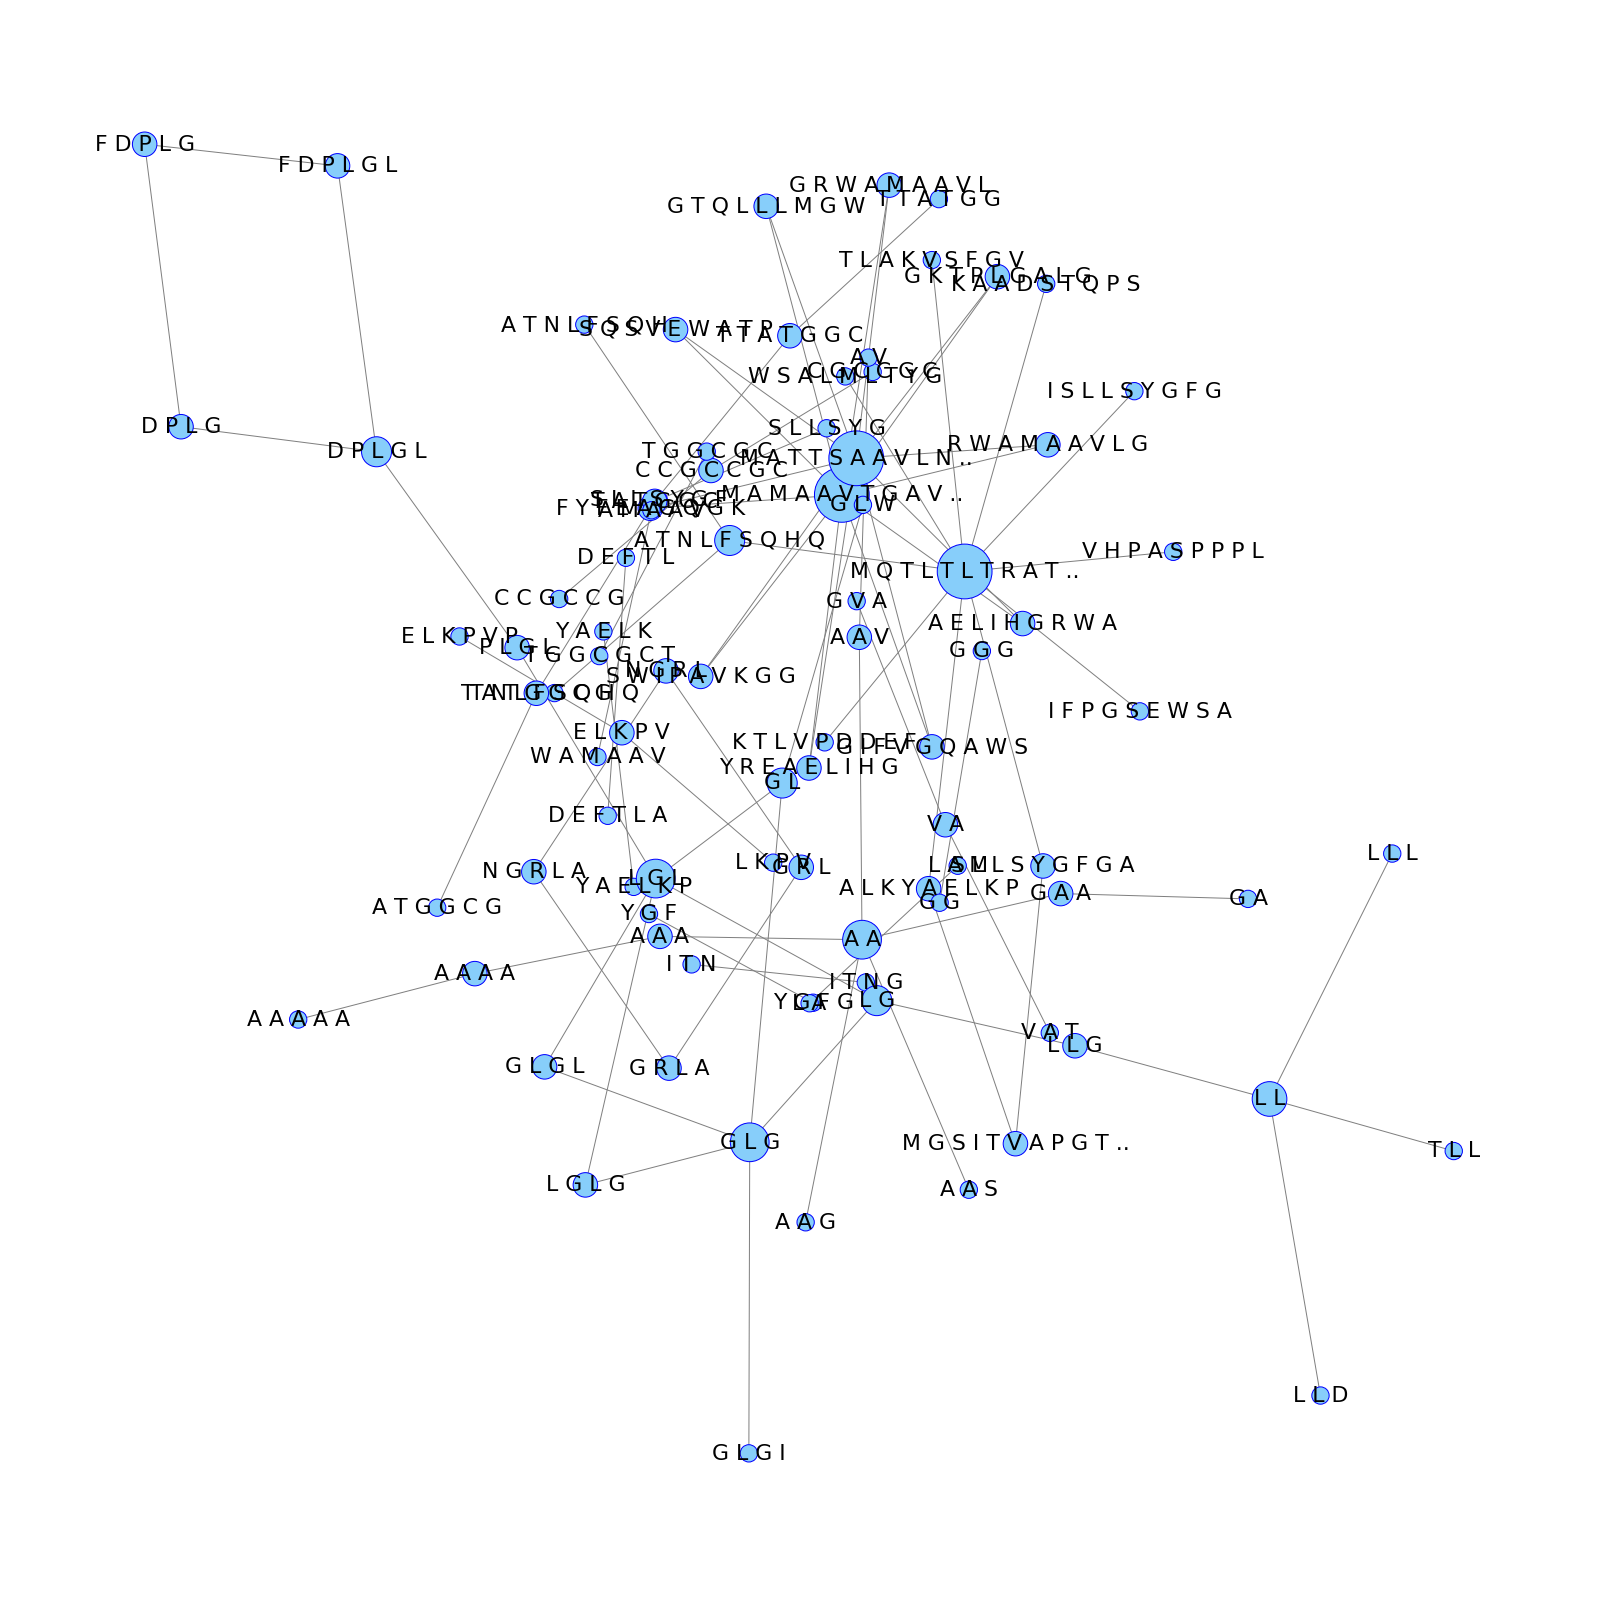

In [43]:
ff = pd.DataFrame(graph_lst)
ff.columns = ['Target','Source','Weight']
ff = ff[ff['Weight'] > 1.5]
build_graph_network(ff)

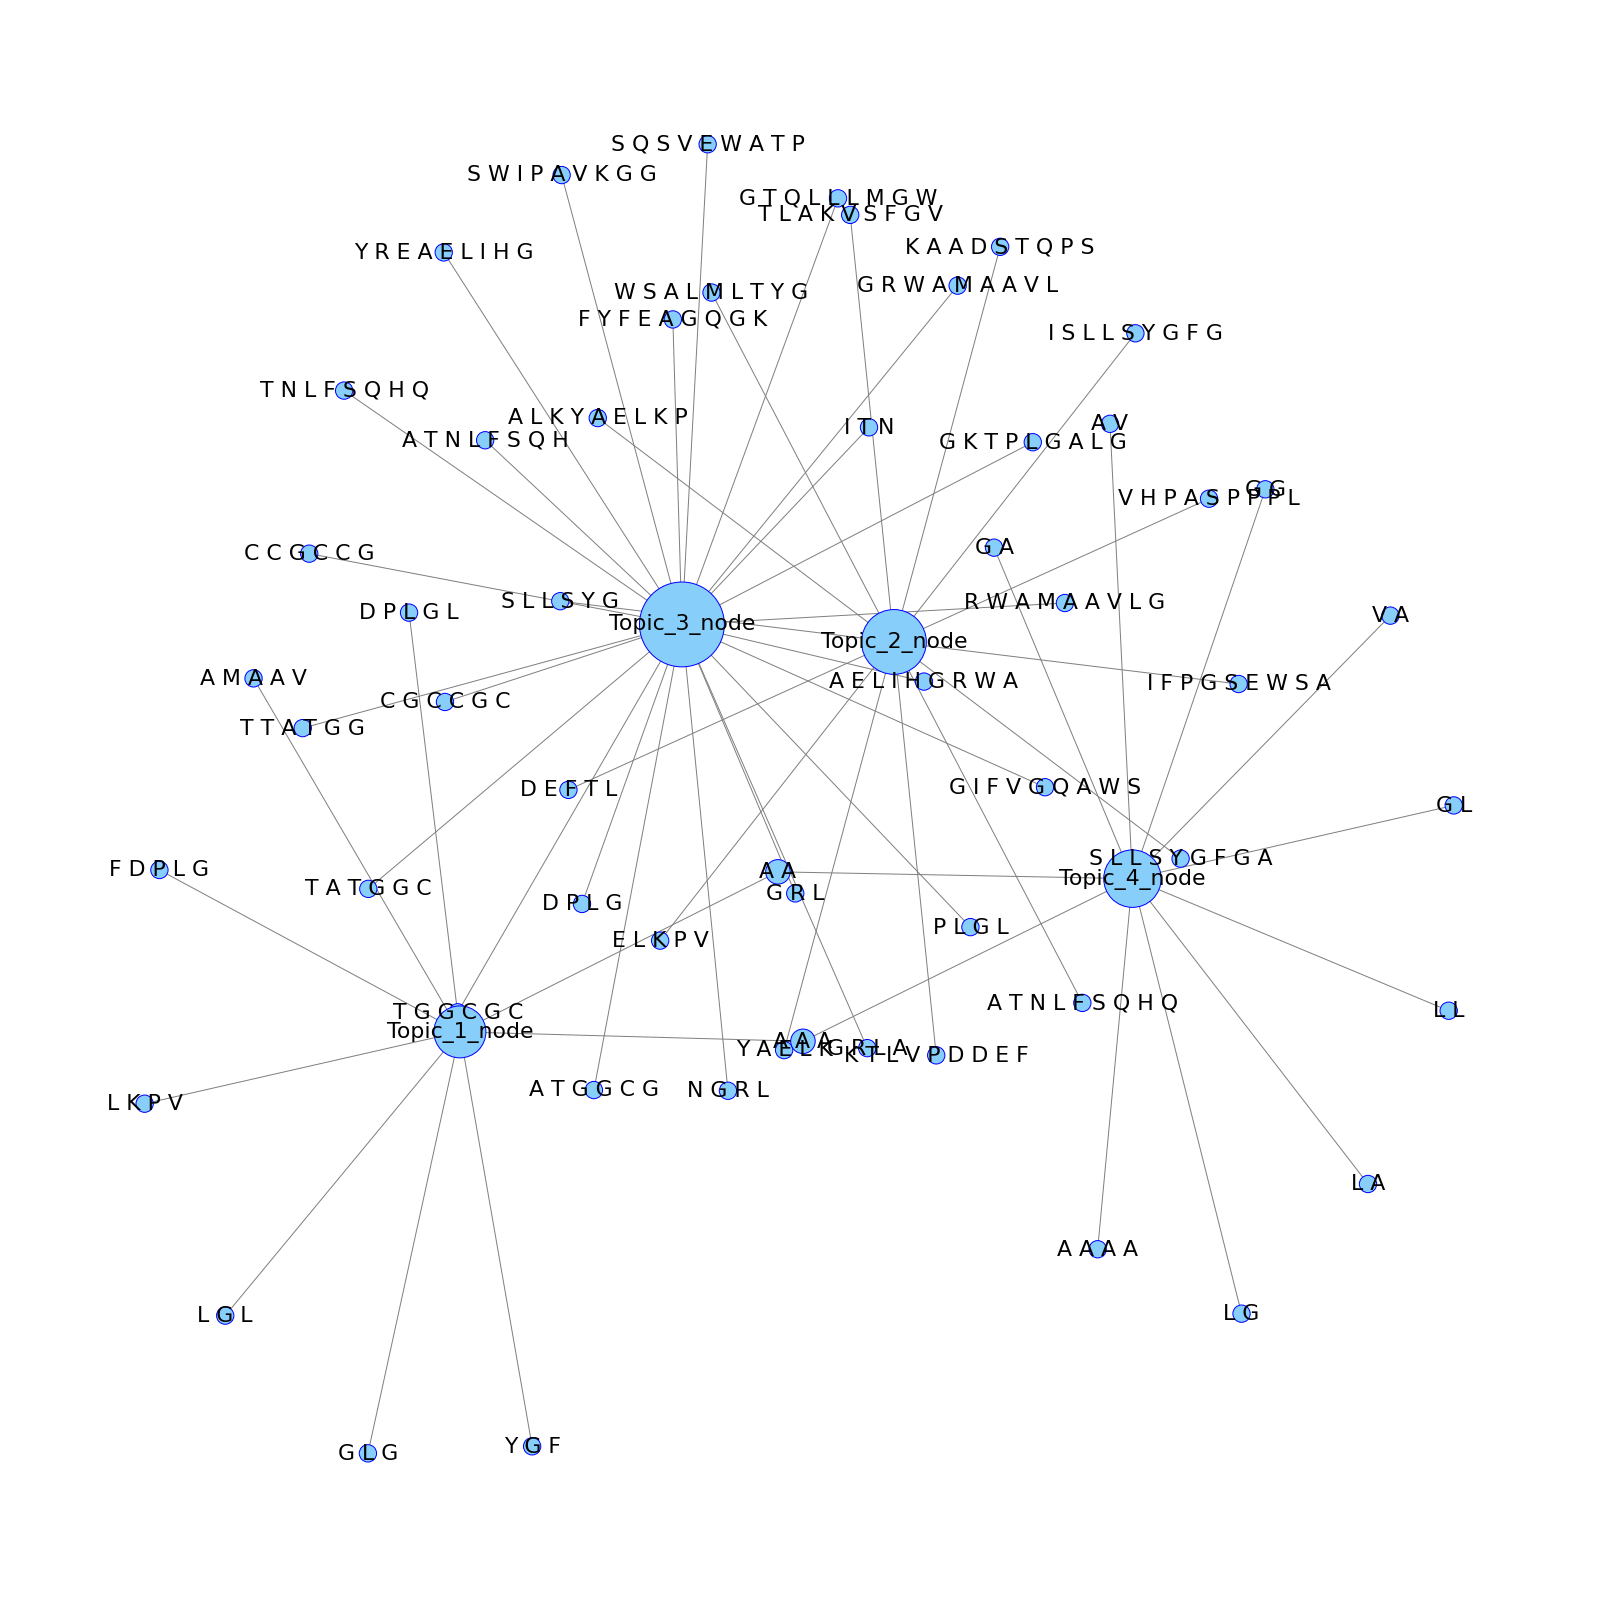

In [44]:
ff = pd.DataFrame(graph_node_lst)
ff.columns = ['Target','Source','Weight']
ff = ff[ff['Weight'] > 1.5]
build_graph_network(ff)

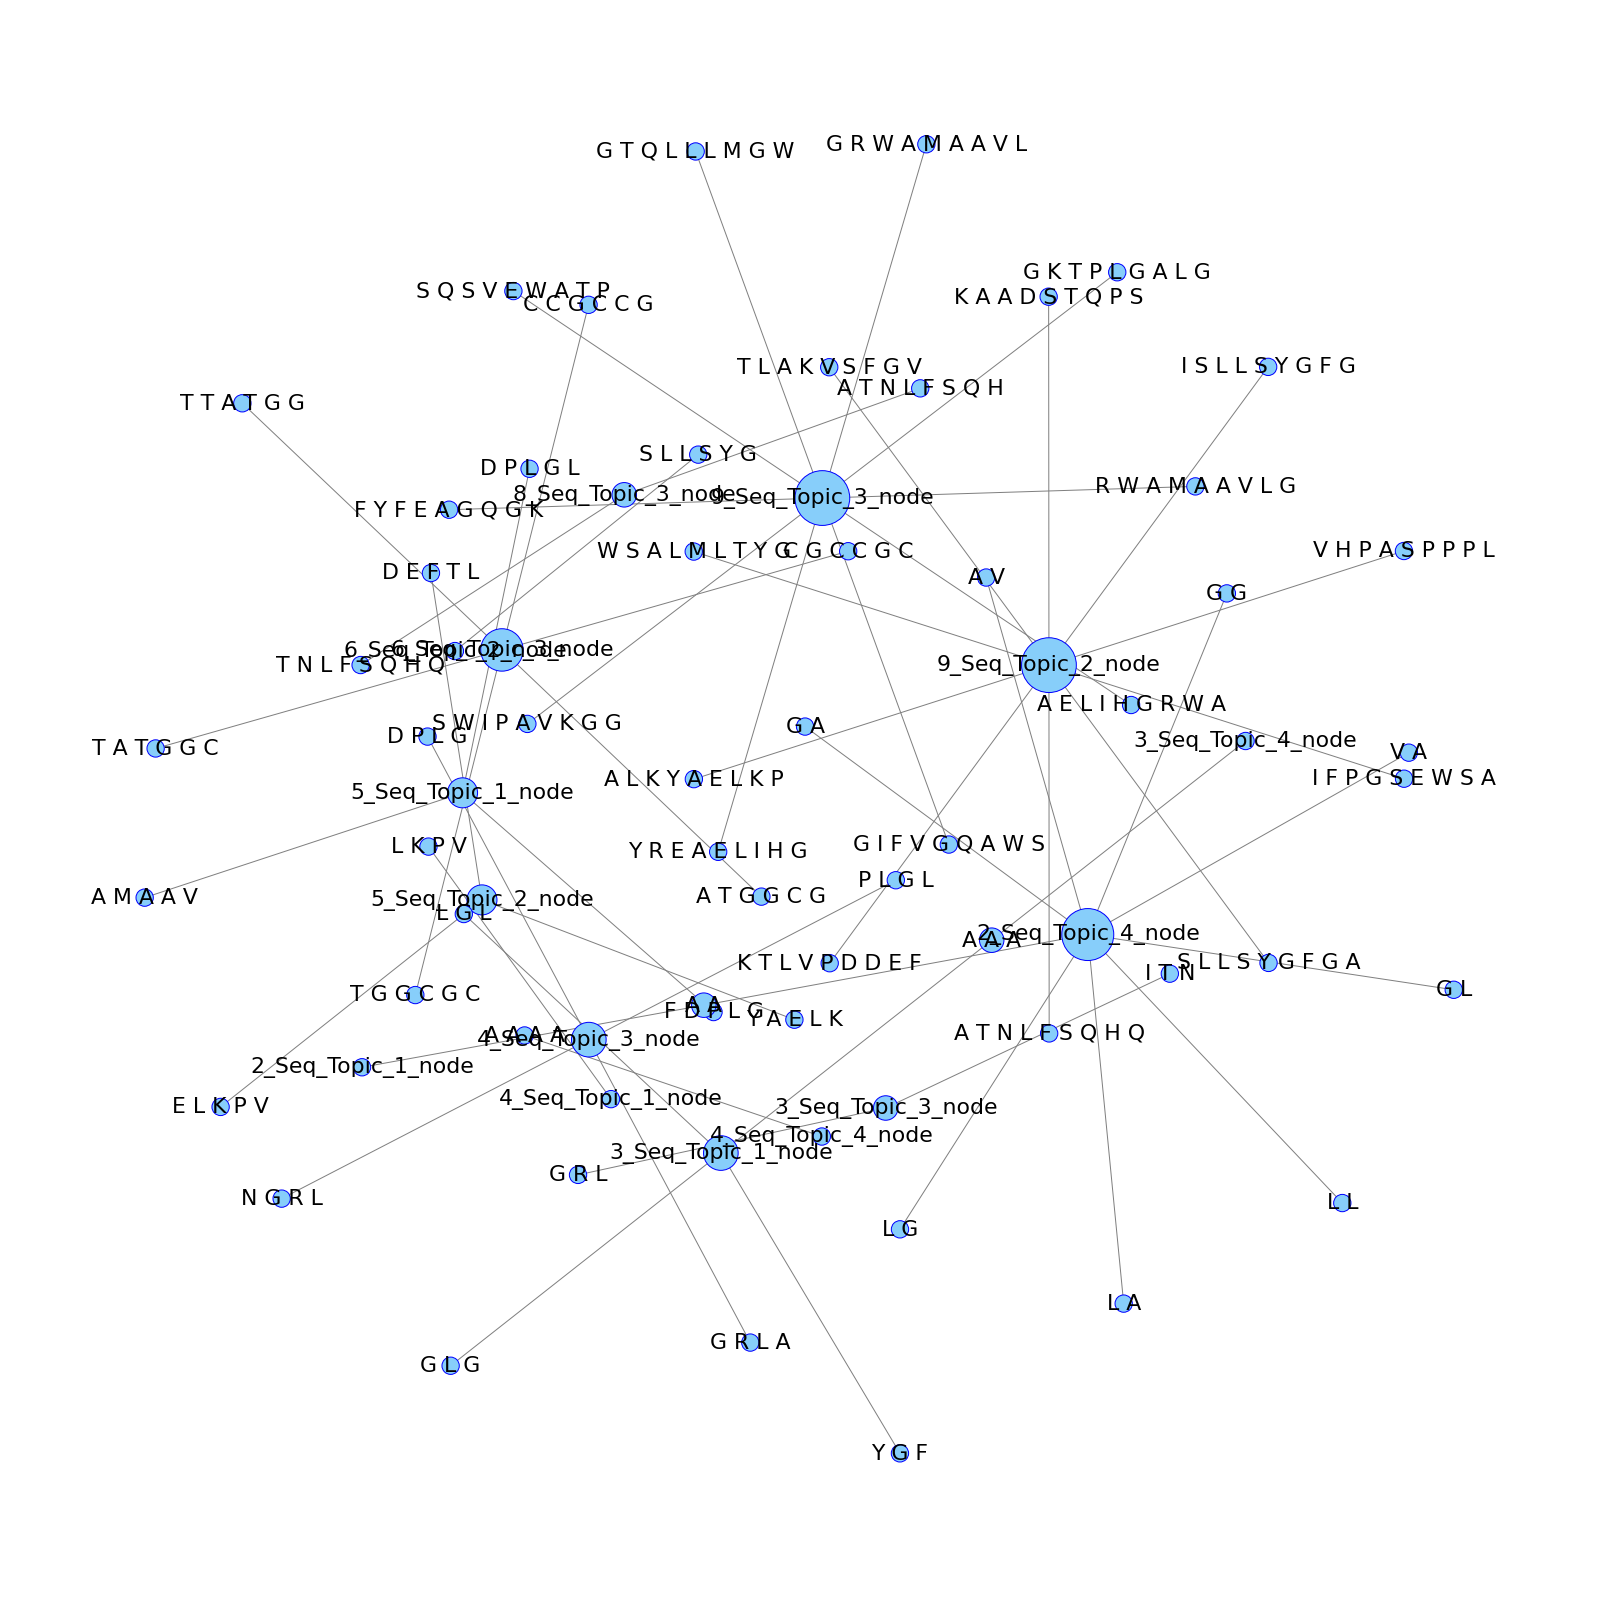

In [45]:
ff = pd.DataFrame(graph_specific_node_lst)
ff.columns = ['Target','Source','Weight']
ff = ff[ff['Weight'] > 1.5]
build_graph_network(ff)